In [1]:
!pip install h5py
!pip install typing-extensions
!pip install wheel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px
import statsmodels.api as sm
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

### 1. Business Problem
#### At firstly we are doing regional sales for each product and find sales metric for each product. After this, we do clustering for each product.
#### And the we are looking Time Series. 
#### And then, if we can find the possible patterns in this visualitons, we use SARIMAX model for sales prediction
### 2. Data Understanding
#### We use check_df function for understanding our data sets and their relations.
### 3. Data Cleaning
#### After cleaning untidy data, we start to visualize the critic datasets in their sub categoric columns.
### 4. EDA

## 2. Data Understanding

In [2]:
i_df = pd.read_csv('inventory.csv')
p_df = pd.read_csv('products.csv')
s_df = pd.read_csv('sales.csv')
st_df = pd.read_csv('stores.csv')

In [3]:
def check_df(dataframe, head):
    print("##################### Shape/Satır ve Sütun #####################")
    print(dataframe.shape)
    print("##################### Types/Veri Tipleri #####################")
    print(dataframe.dtypes)
    print("##################### Head/İlk 3 satır #####################")
    print(dataframe.head(head))
    print("##################### Tail/Son 3 satır #####################")
    print(dataframe.tail(head))
    print("##################### NA/Boş veri #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles/Sayısal Kritikler #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### Nunique/Unik veri sayısı #####################")
    print(dataframe.nunique().T)

In [4]:
df_list = [i_df, p_df, s_df, st_df]

In [5]:
for i in df_list:
    print("---------")
    print(check_df(i,3))

---------
##################### Shape/Satır ve Sütun #####################
(1593, 3)
##################### Types/Veri Tipleri #####################
Store_ID         int64
Product_ID       int64
Stock_On_Hand    int64
dtype: object
##################### Head/İlk 3 satır #####################
   Store_ID  Product_ID  Stock_On_Hand
0         1           1             27
1         1           2              0
2         1           3             32
##################### Tail/Son 3 satır #####################
      Store_ID  Product_ID  Stock_On_Hand
1590        50          33              1
1591        50          34             17
1592        50          35              8
##################### NA/Boş veri #####################
Store_ID         0
Product_ID       0
Stock_On_Hand    0
dtype: int64
##################### Quantiles/Sayısal Kritikler #####################
                count       mean        std  min   0%   5%   50%   95%   99%  \
Store_ID       1593.0  25.326428  14.477592  

Aşağıdaki veri tipleri düzenlenmelidir.
* Product : Product_Cost        object
* Product : Product_Price       object
* Sales : Date               object
* Store : Store_Open_Date    object

In [6]:
s_df['Date'] = pd.to_datetime(s_df['Date'])
st_df['Store_Open_Date'] = pd.to_datetime(st_df['Store_Open_Date'])
sales0 = pd.merge(s_df, p_df, on='Product_ID')
sales1 = pd.merge(sales0, st_df, on='Store_ID')

In [7]:
s_df.head()

,Sale_ID,Date,Store_ID,Product_ID,Units
0,1,2017-01-01,24,4,1
1,2,2017-01-01,28,1,1
2,3,2017-01-01,6,8,1
3,4,2017-01-01,48,7,1
4,5,2017-01-01,44,18,1


In [8]:
p_df.head()

,Product_ID,Product_Name,Product_Category,Product_Cost,Product_Price
0,1,Action Figure,Toys,$9.99,$15.99
1,2,Animal Figures,Toys,$9.99,$12.99
2,3,Barrel O' Slime,Art & Crafts,$1.99,$3.99
3,4,Chutes & Ladders,Games,$9.99,$12.99
4,5,Classic Dominoes,Games,$7.99,$9.99


In [9]:
sales0.head()

,Sale_ID,Date,Store_ID,Product_ID,Units,Product_Name,Product_Category,Product_Cost,Product_Price
0,1,2017-01-01,24,4,1,Chutes & Ladders,Games,$9.99,$12.99
1,66,2017-01-01,24,4,1,Chutes & Ladders,Games,$9.99,$12.99
2,80,2017-01-01,7,4,1,Chutes & Ladders,Games,$9.99,$12.99
3,98,2017-01-01,24,4,1,Chutes & Ladders,Games,$9.99,$12.99
4,128,2017-01-01,24,4,1,Chutes & Ladders,Games,$9.99,$12.99


In [10]:
sales1.tail(10)

,Sale_ID,Date,Store_ID,Product_ID,Units,Product_Name,Product_Category,Product_Cost,Product_Price,Store_Name,Store_City,Store_Location,Store_Open_Date
829252,792603,2018-09-04,13,28,1,Playfoam,Art & Crafts,$3.99,$10.99,Maven Toys Mexicali 2,Mexicali,Downtown,2006-08-30
829253,792827,2018-09-04,13,28,1,Playfoam,Art & Crafts,$3.99,$10.99,Maven Toys Mexicali 2,Mexicali,Downtown,2006-08-30
829254,792861,2018-09-04,13,28,1,Playfoam,Art & Crafts,$3.99,$10.99,Maven Toys Mexicali 2,Mexicali,Downtown,2006-08-30
829255,792908,2018-09-04,13,28,1,Playfoam,Art & Crafts,$3.99,$10.99,Maven Toys Mexicali 2,Mexicali,Downtown,2006-08-30
829256,793137,2018-09-04,13,28,1,Playfoam,Art & Crafts,$3.99,$10.99,Maven Toys Mexicali 2,Mexicali,Downtown,2006-08-30
829257,793189,2018-09-04,13,28,1,Playfoam,Art & Crafts,$3.99,$10.99,Maven Toys Mexicali 2,Mexicali,Downtown,2006-08-30
829258,820255,2018-09-25,13,28,1,Playfoam,Art & Crafts,$3.99,$10.99,Maven Toys Mexicali 2,Mexicali,Downtown,2006-08-30
829259,820290,2018-09-25,13,28,1,Playfoam,Art & Crafts,$3.99,$10.99,Maven Toys Mexicali 2,Mexicali,Downtown,2006-08-30
829260,820877,2018-09-25,13,28,1,Playfoam,Art & Crafts,$3.99,$10.99,Maven Toys Mexicali 2,Mexicali,Downtown,2006-08-30
829261,821027,2018-09-25,13,28,1,Playfoam,Art & Crafts,$3.99,$10.99,Maven Toys Mexicali 2,Mexicali,Downtown,2006-08-30


In [11]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#Uyarilari Kapat
pd.options.mode.chained_assignment = None

## 3. Data Cleaning

In [12]:
sales1['Product_Cost'] = sales1['Product_Cost'].str.replace('$', '')
sales1['Product_Cost'] = sales1['Product_Cost'].str.replace(' ', '')
sales1['Product_Price'] = sales1['Product_Price'].str.replace('$', '')
sales1['Product_Price'] = sales1['Product_Price'].str.replace(' ', '')

sales1['Product_Cost'] = sales1['Product_Cost'].astype(float)
sales1['Product_Price'] = sales1['Product_Price'].astype(float)

/var/folders/j1/j1wfy5tn6pl66v9rmgzq4pd00000gn/T/ipykernel_14388/1070307326.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sales1['Product_Cost'] = sales1['Product_Cost'].str.replace('$', '')
/var/folders/j1/j1wfy5tn6pl66v9rmgzq4pd00000gn/T/ipykernel_14388/1070307326.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sales1['Product_Price'] = sales1['Product_Price'].str.replace('$', '')


In [13]:
sales1['sales'] = sales1['Units'] * sales1['Product_Price']
sales1['cost'] = sales1['Units'] * sales1['Product_Cost']
sales1['Date'] = pd.to_datetime(sales1['Date'])
sales1.head()

,Sale_ID,Date,Store_ID,Product_ID,Units,Product_Name,Product_Category,Product_Cost,Product_Price,Store_Name,Store_City,Store_Location,Store_Open_Date,sales,cost
0,1,2017-01-01,24,4,1,Chutes & Ladders,Games,9.99,12.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
1,66,2017-01-01,24,4,1,Chutes & Ladders,Games,9.99,12.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
2,98,2017-01-01,24,4,1,Chutes & Ladders,Games,9.99,12.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
3,128,2017-01-01,24,4,1,Chutes & Ladders,Games,9.99,12.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
4,146,2017-01-01,24,4,1,Chutes & Ladders,Games,9.99,12.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99


In [14]:
sales1.nunique()

Sale_ID             829262
Date                   638
Store_ID                50
Product_ID              35
Units                   27
Product_Name            35
Product_Category         5
Product_Cost            16
Product_Price           18
Store_Name              50
Store_City              29
Store_Location           4
Store_Open_Date         50
sales                  193
cost                   179
dtype: int64

In [15]:
sales1.columns

Index(['Sale_ID', 'Date', 'Store_ID', 'Product_ID', 'Units', 'Product_Name',
       'Product_Category', 'Product_Cost', 'Product_Price', 'Store_Name',
       'Store_City', 'Store_Location', 'Store_Open_Date', 'sales', 'cost'],
      dtype='object')

In [16]:
sales2 = sales1[['Sale_ID', 'Date', 'Units', 'Product_Name','Product_Category', 'Store_Name','Store_City',
       'Store_Location', 'Store_Open_Date', 'sales', 'cost']]

In [17]:
sales2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 829262 entries, 0 to 829261
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Sale_ID           829262 non-null  int64         
 1   Date              829262 non-null  datetime64[ns]
 2   Units             829262 non-null  int64         
 3   Product_Name      829262 non-null  object        
 4   Product_Category  829262 non-null  object        
 5   Store_Name        829262 non-null  object        
 6   Store_City        829262 non-null  object        
 7   Store_Location    829262 non-null  object        
 8   Store_Open_Date   829262 non-null  datetime64[ns]
 9   sales             829262 non-null  float64       
 10  cost              829262 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 75.9+ MB


In [18]:
sales2.isnull().sum()

Sale_ID             0
Date                0
Units               0
Product_Name        0
Product_Category    0
Store_Name          0
Store_City          0
Store_Location      0
Store_Open_Date     0
sales               0
cost                0
dtype: int64

In [19]:
sales2.nunique()

Sale_ID             829262
Date                   638
Units                   27
Product_Name            35
Product_Category         5
Store_Name              50
Store_City              29
Store_Location           4
Store_Open_Date         50
sales                  193
cost                   179
dtype: int64

## 4. Exploration Data Analysis

/var/folders/j1/j1wfy5tn6pl66v9rmgzq4pd00000gn/T/ipykernel_14388/169766938.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales2.groupby(['Store_City','Product_Category']).sum().unstack().plot(kind='barh',y='sales', stacked=True, figsize=(20, 10))


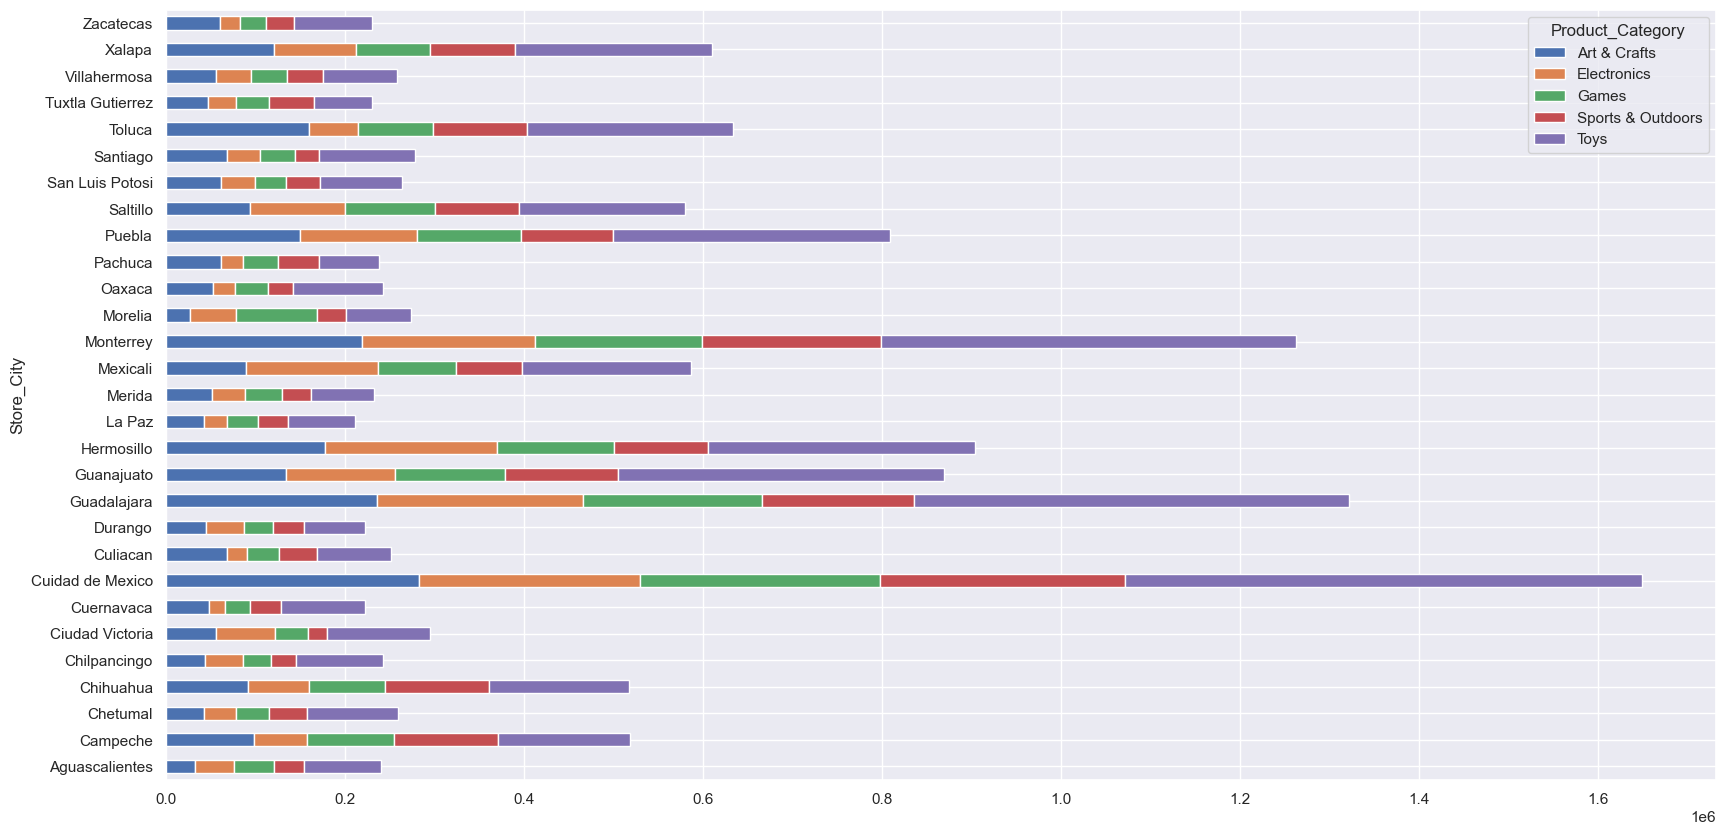

In [20]:
sales2.groupby(['Store_City','Product_Category']).sum().unstack().plot(kind='barh',y='sales', stacked=True, figsize=(20, 10))
plt.show()
#Toys category the most highest sales category for all store_city

In [21]:
sales2.groupby(['Product_Category'])['sales'].sum().sort_values(ascending=False)

Product_Category
Toys                5093241.00
Art & Crafts        2705364.26
Electronics         2246771.25
Games               2226836.27
Sports & Outdoors   2172359.57
Name: sales, dtype: float64

In [22]:
sales2.groupby(['Store_Name'])["Units", "sales", "cost"].sum().sort_values(by="sales", ascending=False).head()

/var/folders/j1/j1wfy5tn6pl66v9rmgzq4pd00000gn/T/ipykernel_14388/3109716508.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sales2.groupby(['Store_Name'])["Units", "sales", "cost"].sum().sort_values(by="sales", ascending=False).head()


,Units,sales,cost
Store_Name,,,
Maven Toys Ciudad de Mexico 2,42757,554553.43,384697.43
Maven Toys Guadalajara 3,31609,449354.91,327783.91
Maven Toys Ciudad de Mexico 1,33479,433556.21,322260.21
Maven Toys Toluca 1,32668,411157.32,306545.32
Maven Toys Monterrey 2,28318,372998.82,266215.82


/var/folders/j1/j1wfy5tn6pl66v9rmgzq4pd00000gn/T/ipykernel_14388/2645231324.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales2.groupby(['Store_Name','Product_Category']).sum().unstack().plot(kind='barh',y='sales', stacked=True, figsize=(15, 15))


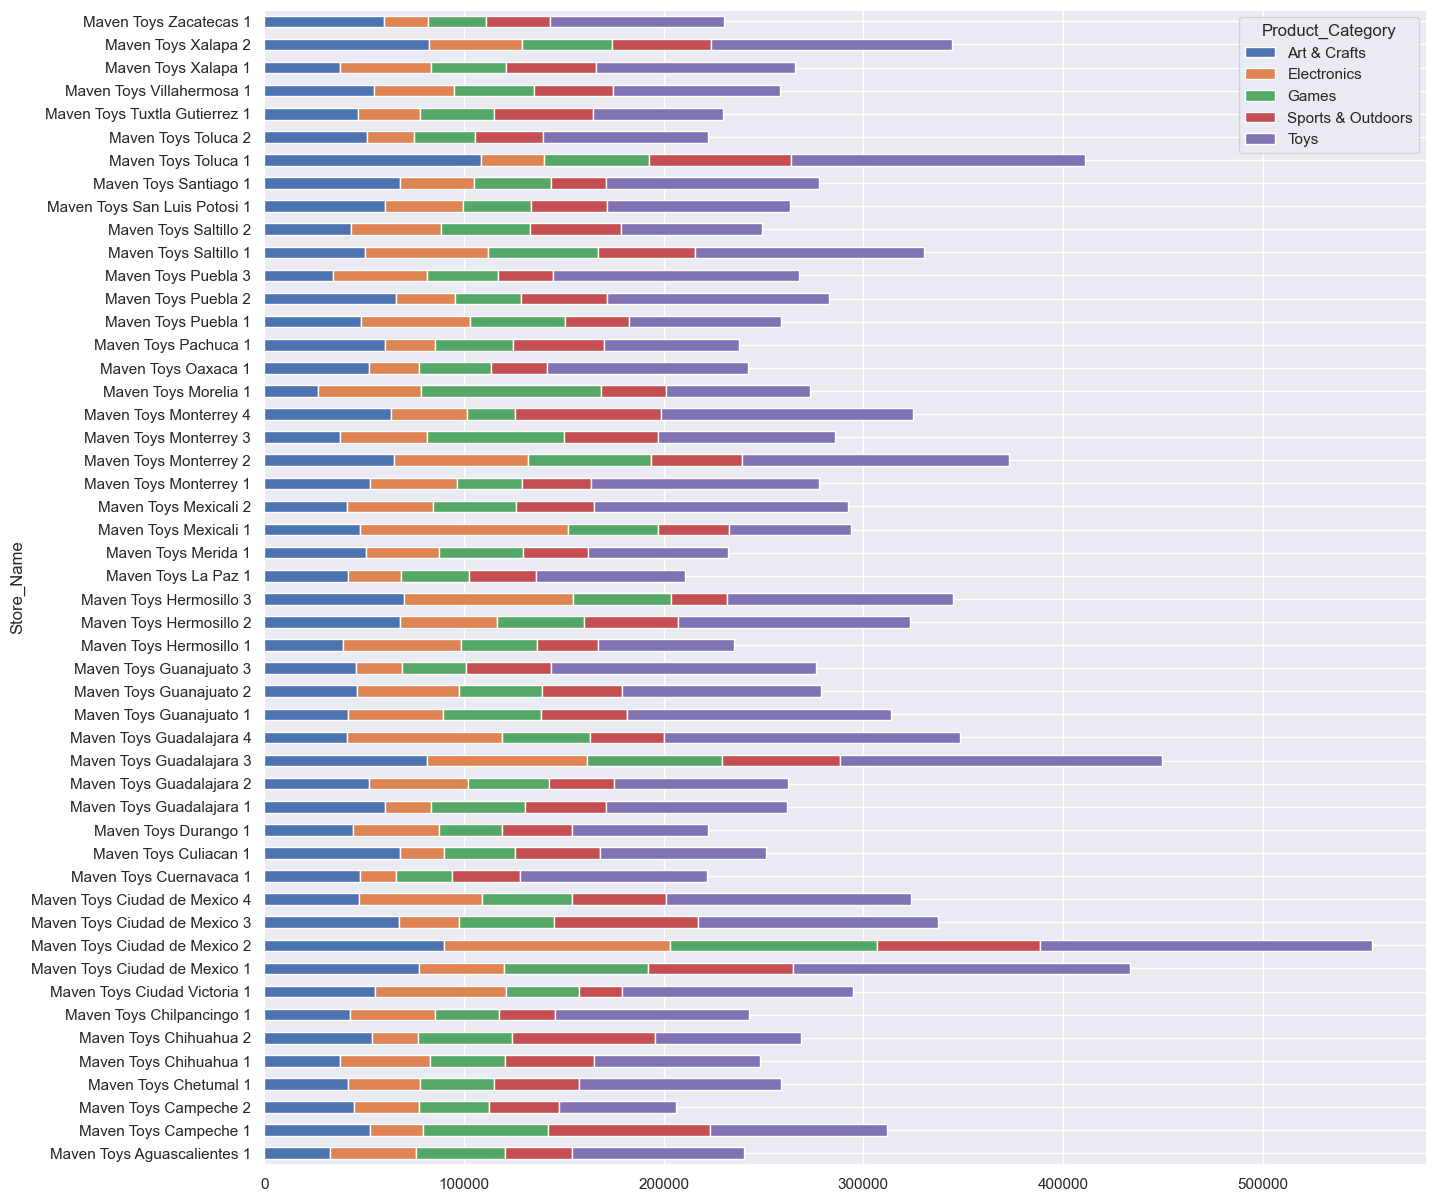

In [23]:
sales2.groupby(['Store_Name','Product_Category']).sum().unstack().plot(kind='barh',y='sales', stacked=True, figsize=(15, 15))
plt.show()

In [24]:
sales2.groupby(['Store_Location','Product_Category'])["Units", "sales", "cost"].sum()

/var/folders/j1/j1wfy5tn6pl66v9rmgzq4pd00000gn/T/ipykernel_14388/592635682.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sales2.groupby(['Store_Location','Product_Category'])["Units", "sales", "cost"].sum()


Units      sales       cost
Store_Location Product_Category                               
Airport        Art & Crafts        24833  209363.67  147922.67
               Electronics         14347  236496.53  128299.53
               Games               21390  240004.10  159236.10
               Sports & Outdoors   14368  188103.32  148710.32
               Toys                21504  415754.96  327504.96
Commercial     Art & Crafts        65147  591698.53  436237.53
               Electronics         38258  634885.42  347311.42
               Games               42693  478165.07  331869.07
               Sports & Outdoors   38532  493071.68  380572.68
               Toys                56018 1081318.82  856284.82
Downtown       Art & Crafts       196933 1604073.67 1159753.67
               Electronics         67799 1149769.01  647279.01
               Games              109875 1275828.25  897407.25
               Sports & Outdoors   97285 1243170.15  949702.15
               Toys               156181 2946755.19 2316726.19
Residential    Art & Crafts        38661  300228.39  208096.39
               Electronics         13671  225620.29  122444.29
               Games               20715  232838.85  164330.85
               Sports & Outdoors   18858  248014.42  187656.42
               Toys                33497  649412.03  513198.03

/var/folders/j1/j1wfy5tn6pl66v9rmgzq4pd00000gn/T/ipykernel_14388/4182624398.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales2.groupby(['Store_Location','Product_Category']).sum().unstack().plot(kind='bar',y='sales', stacked=True, figsize=(8, 8))


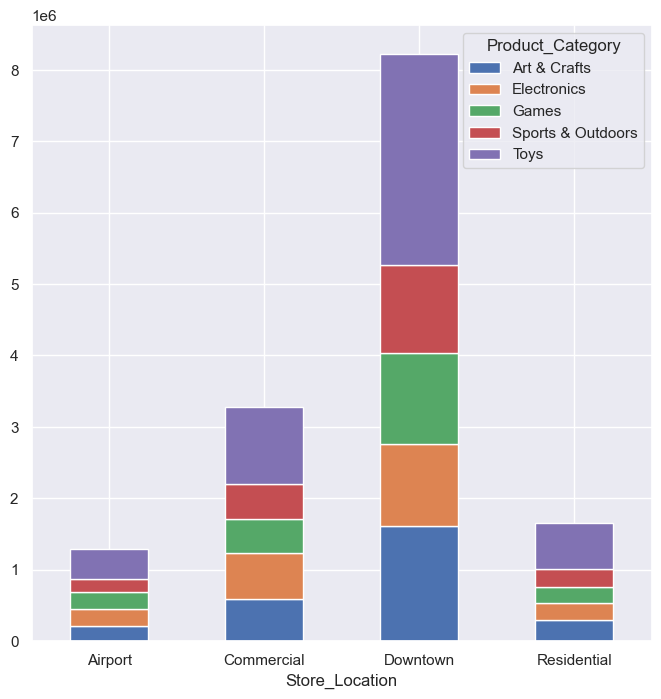

In [25]:
sales2.groupby(['Store_Location','Product_Category']).sum().unstack().plot(kind='bar',y='sales', stacked=True, figsize=(8, 8))
plt.xticks(rotation=0)
plt.show()

In [26]:
sales2.head()

,Sale_ID,Date,Units,Product_Name,Product_Category,Store_Name,Store_City,Store_Location,Store_Open_Date,sales,cost
0,1,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
1,66,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
2,98,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
3,128,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
4,146,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99


In [27]:
sales2_profit = sales2.groupby(['Product_Name'])["Units", "sales", "cost"].sum().sort_values(by="sales", ascending=False)

/var/folders/j1/j1wfy5tn6pl66v9rmgzq4pd00000gn/T/ipykernel_14388/2872731961.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sales2_profit = sales2.groupby(['Product_Name'])["Units", "sales", "cost"].sum().sort_values(by="sales", ascending=False)


In [28]:
sales2_profit.columns = ['units_sum', 'sales_sum', 'cost_sum']

In [29]:
sales2_profit["profit"] = sales2_profit["sales_sum"] - sales2_profit['cost_sum']
sales2_profit["profit_margin"] = (sales2_profit["profit"] / sales2_profit['sales_sum']) * 100
sales2_profit["unit_profit"] = sales2_profit["profit"] / sales2_profit['units_sum']

In [30]:
sales2_profit.sort_values(by=["profit_margin"], ascending = False)

,units_sum,sales_sum,cost_sum,profit,profit_margin,unit_profit
Product_Name,,,,,,
Jenga,13054,130409.46,39031.46,91378.00,70.07,7.00
Mini Basketball Hoop,2647,66148.53,23796.53,42352.00,64.03,16.00
Playfoam,4158,45696.42,16590.42,29106.00,63.69,7.00
Plush Pony,5488,109705.12,49337.12,60368.00,55.03,11.00
Colorbuds,104368,1564476.32,729532.32,834944.00,53.37,8.00
Barrel O' Slime,91663,365735.37,182409.37,183326.00,50.13,2.00
Uno Card Game,2710,21652.90,10812.90,10840.00,50.06,4.00
Mr. Potatohead,8605,85963.95,42938.95,43025.00,50.05,5.00
Etch A Sketch,12168,255406.32,133726.32,121680.00,47.64,10.00


/var/folders/j1/j1wfy5tn6pl66v9rmgzq4pd00000gn/T/ipykernel_14388/773936948.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales2.groupby(['Product_Name','Store_Location']).sum().unstack().plot(kind='barh',y='sales', stacked=True, figsize=(8, 8))


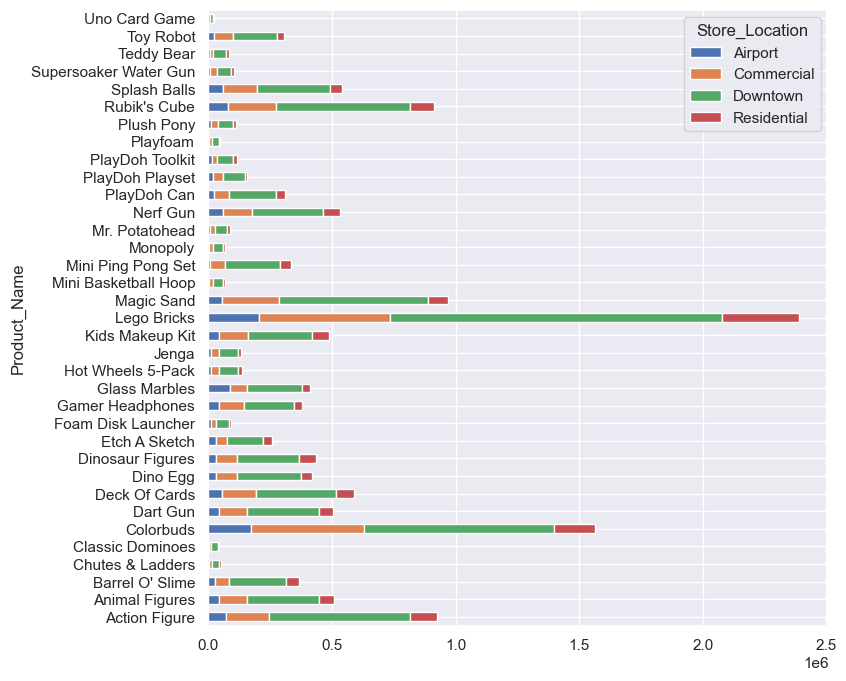

In [31]:
sales2.groupby(['Product_Name','Store_Location']).sum().unstack().plot(kind='barh',y='sales', stacked=True, figsize=(8, 8))
plt.xticks(rotation=0)
plt.show()

In [32]:
sales_beta = sales2.groupby(['Product_Name','Product_Category','Store_Location'])["Units", "sales", "cost"].sum()

/var/folders/j1/j1wfy5tn6pl66v9rmgzq4pd00000gn/T/ipykernel_14388/1973419157.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sales_beta = sales2.groupby(['Product_Name','Product_Category','Store_Location'])["Units", "sales", "cost"].sum()


In [33]:
sales_beta.columns = ['units_sum', 'sales_sum', 'cost_sum']

In [34]:
sales_beta["profit"] = sales_beta["sales_sum"] - sales_beta['cost_sum']
sales_beta["profit_margin"] = (sales_beta["profit"] / sales_beta['sales_sum']) * 100
sales_beta["unit_profit"] = sales_beta["profit"] / sales_beta['units_sum']

In [35]:
sales_beta.reset_index(inplace=True)
sales_beta.columns = ["Product_Name", "Product_Category", "Store_Location", 'units_sum', 'sales_sum', 'cost_sum', "profit", "profit_margin", "unit_profit"]
sales_beta.shape

(140, 9)

In [36]:
sales_beta.head()

,Product_Name,Product_Category,Store_Location,units_sum,sales_sum,cost_sum,profit,profit_margin,unit_profit
0,Action Figure,Toys,Airport,4407,70467.93,44025.93,26442.00,37.52,6.00
1,Action Figure,Toys,Commercial,10833,173219.67,108221.67,64998.00,37.52,6.00
2,Action Figure,Toys,Downtown,35716,571098.84,356802.84,214296.00,37.52,6.00
3,Action Figure,Toys,Residential,7002,111961.98,69949.98,42012.00,37.52,6.00
4,Animal Figures,Toys,Airport,3214,41749.86,32107.86,9642.00,23.09,3.00


In [37]:
sales_beta.groupby(["Product_Name"])['units_sum', 'sales_sum', 'cost_sum'].sum()

/var/folders/j1/j1wfy5tn6pl66v9rmgzq4pd00000gn/T/ipykernel_14388/3129316328.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sales_beta.groupby(["Product_Name"])['units_sum', 'sales_sum', 'cost_sum'].sum()


,units_sum,sales_sum,cost_sum
Product_Name,,,
Action Figure,57958,926748.42,579000.42
Animal Figures,39089,507766.11,390499.11
Barrel O' Slime,91663,365735.37,182409.37
Chutes & Ladders,3829,49738.71,38251.71
Classic Dominoes,4471,44665.29,35723.29
Colorbuds,104368,1564476.32,729532.32
Dart Gun,31588,505092.12,378740.12
Deck Of Cards,84034,587397.66,335295.66
Dino Egg,38236,420213.64,381977.64


In [38]:
sales2.head()

,Sale_ID,Date,Units,Product_Name,Product_Category,Store_Name,Store_City,Store_Location,Store_Open_Date,sales,cost
0,1,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
1,66,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
2,98,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
3,128,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
4,146,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99


In [39]:
sales2["Date"].max()

Timestamp('2018-09-30 00:00:00')

In [40]:
import datetime as dt
today_date = dt.datetime(2018, 10, 10)
print(today_date)

2018-10-10 00:00:00


In [41]:
sales_product = sales2.groupby(['Product_Name','Product_Category','Store_Location']).agg({'Date': ['min', 'max'], "Units" : 'sum' , "sales" : 'sum' , "cost": 'sum', "Sale_ID" : 'count'})

In [42]:
sales_product.head()

Date             Units  \
                                                      min        max    sum   
Product_Name   Product_Category Store_Location                                
Action Figure  Toys             Airport        2017-01-01 2018-09-28   4407   
                                Commercial     2017-01-02 2018-09-29  10833   
                                Downtown       2017-01-01 2018-09-30  35716   
                                Residential    2017-01-02 2018-09-30   7002   
Animal Figures Toys             Airport        2017-01-01 2018-09-20   3214   

                                                   sales      cost Sale_ID  
                                                     sum       sum   count  
Product_Name   Product_Category Store_Location                              
Action Figure  Toys             Airport         70467.93  44025.93    3656  
                                Commercial     173219.67 108221.67    9185  
                                Downtown       571098.84 356802.84   29734  
                                Residential    111961.98  69949.98    5922  
Animal Figures Toys             Airport         41749.86  32107.86    2506

In [43]:
sales_product.reset_index(inplace=True)
sales_product.columns = ["Product_Name", "Product_Category", "Store_Location", 'date_min', 'date_max', 'unit_sum', "sales_sum", "cost_sum", "frequency"]
sales_product.shape

(140, 9)

In [44]:
sales_product.head()

,Product_Name,Product_Category,Store_Location,date_min,date_max,unit_sum,sales_sum,cost_sum,frequency
0,Action Figure,Toys,Airport,2017-01-01,2018-09-28,4407,70467.93,44025.93,3656
1,Action Figure,Toys,Commercial,2017-01-02,2018-09-29,10833,173219.67,108221.67,9185
2,Action Figure,Toys,Downtown,2017-01-01,2018-09-30,35716,571098.84,356802.84,29734
3,Action Figure,Toys,Residential,2017-01-02,2018-09-30,7002,111961.98,69949.98,5922
4,Animal Figures,Toys,Airport,2017-01-01,2018-09-20,3214,41749.86,32107.86,2506


In [45]:
sales_product["profit"] = sales_product["sales_sum"] - sales_product['cost_sum']
sales_product["profit_margin"] = (sales_product["profit"] / sales_product['sales_sum']) * 100
sales_product["unit_profit"] = sales_product["profit"] / sales_product['unit_sum']
sales_product["tenure"] = (sales_product["date_max"] - sales_product['date_min'])
sales_product["recency"] = (today_date - sales_product['date_max'])

In [46]:
sales_product.head()

,Product_Name,Product_Category,Store_Location,date_min,date_max,unit_sum,sales_sum,cost_sum,frequency,profit,profit_margin,unit_profit,tenure,recency
0,Action Figure,Toys,Airport,2017-01-01,2018-09-28,4407,70467.93,44025.93,3656,26442.00,37.52,6.00,635 days,12 days
1,Action Figure,Toys,Commercial,2017-01-02,2018-09-29,10833,173219.67,108221.67,9185,64998.00,37.52,6.00,635 days,11 days
2,Action Figure,Toys,Downtown,2017-01-01,2018-09-30,35716,571098.84,356802.84,29734,214296.00,37.52,6.00,637 days,10 days
3,Action Figure,Toys,Residential,2017-01-02,2018-09-30,7002,111961.98,69949.98,5922,42012.00,37.52,6.00,636 days,10 days
4,Animal Figures,Toys,Airport,2017-01-01,2018-09-20,3214,41749.86,32107.86,2506,9642.00,23.09,3.00,627 days,20 days


In [47]:
sales_product.columns

Index(['Product_Name', 'Product_Category', 'Store_Location', 'date_min',
       'date_max', 'unit_sum', 'sales_sum', 'cost_sum', 'frequency', 'profit',
       'profit_margin', 'unit_profit', 'tenure', 'recency'],
      dtype='object')

In [48]:
local_sales_product = sales_product[['Product_Name', 'Product_Category', 'Store_Location', 'frequency','tenure', 'recency','profit',
       'profit_margin', 'unit_profit','unit_sum']]

In [49]:
local_sales_product.head()

,Product_Name,Product_Category,Store_Location,frequency,tenure,recency,profit,profit_margin,unit_profit,unit_sum
0,Action Figure,Toys,Airport,3656,635 days,12 days,26442.00,37.52,6.00,4407
1,Action Figure,Toys,Commercial,9185,635 days,11 days,64998.00,37.52,6.00,10833
2,Action Figure,Toys,Downtown,29734,637 days,10 days,214296.00,37.52,6.00,35716
3,Action Figure,Toys,Residential,5922,636 days,10 days,42012.00,37.52,6.00,7002
4,Animal Figures,Toys,Airport,2506,627 days,20 days,9642.00,23.09,3.00,3214


In [50]:
sales2.nunique()

Sale_ID             829262
Date                   638
Units                   27
Product_Name            35
Product_Category         5
Store_Name              50
Store_City              29
Store_Location           4
Store_Open_Date         50
sales                  193
cost                   179
dtype: int64

In [51]:
sales2.head()

,Sale_ID,Date,Units,Product_Name,Product_Category,Store_Name,Store_City,Store_Location,Store_Open_Date,sales,cost
0,1,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
1,66,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
2,98,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
3,128,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
4,146,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99


In [52]:
rfm = sales2.groupby(['Product_Name','Product_Category','Store_Location']).agg({'Date': lambda date: (today_date - date.max()).days,
                                     'Sale_ID': lambda Sale_ID: Sale_ID.nunique(),
                                     'Store_Open_Date': lambda Store_Open_Date: Store_Open_Date.nunique(),                                           
                                     'Units' : lambda Units: Units.sum(),
                                     'sales': lambda sales: sales.sum(),
                                     'cost': lambda cost: cost.sum()}).astype(int)

In [53]:
rfm.head()

Date  Sale_ID  \
Product_Name   Product_Category Store_Location                  
Action Figure  Toys             Airport           12     3656   
                                Commercial        11     9185   
                                Downtown          10    29734   
                                Residential       10     5922   
Animal Figures Toys             Airport           20     2506   

                                                Store_Open_Date  Units  \
Product_Name   Product_Category Store_Location                           
Action Figure  Toys             Airport                       3   4407   
                                Commercial                   12  10833   
                                Downtown                     29  35716   
                                Residential                   6   7002   
Animal Figures Toys             Airport                       3   3214   

                                                 sales    cost  
Product_Name   Product_Category Store_Location                  
Action Figure  Toys             Airport          70467   44025  
                                Commercial      173219  108221  
                                Downtown        571098  356802  
                                Residential     111961   69949  
Animal Figures Toys             Airport          41749   32107

In [54]:
rfm.reset_index(inplace=True)
rfm.columns = ["Product_Name", "Product_Category", "Store_Location", 'recency', 'frequency','store_total', 'unit_total', "sales_total", "cost_total"]
sales_product.shape

(140, 14)

In [55]:
rfm.head()

,Product_Name,Product_Category,Store_Location,recency,frequency,store_total,unit_total,sales_total,cost_total
0,Action Figure,Toys,Airport,12,3656,3,4407,70467,44025
1,Action Figure,Toys,Commercial,11,9185,12,10833,173219,108221
2,Action Figure,Toys,Downtown,10,29734,29,35716,571098,356802
3,Action Figure,Toys,Residential,10,5922,6,7002,111961,69949
4,Animal Figures,Toys,Airport,20,2506,3,3214,41749,32107


In [56]:
product_rfm = rfm.copy()

In [57]:
product_rfm["profit"] = product_rfm["sales_total"] - product_rfm['cost_total']
product_rfm["profit_margin"] = (product_rfm["profit"] / product_rfm['sales_total']) * 100
product_rfm["unit_profit"] = product_rfm["profit"] / product_rfm['unit_total']
product_rfm["local_monetary"] = product_rfm["profit"] / product_rfm['store_total']
product_rfm["local_unit"] = product_rfm["unit_total"] / product_rfm['store_total']

In [58]:
product_rfm.head()

,Product_Name,Product_Category,Store_Location,recency,frequency,store_total,unit_total,sales_total,cost_total,profit,profit_margin,unit_profit,local_monetary,local_unit
0,Action Figure,Toys,Airport,12,3656,3,4407,70467,44025,26442,37.52,6.00,8814.00,1469.00
1,Action Figure,Toys,Commercial,11,9185,12,10833,173219,108221,64998,37.52,6.00,5416.50,902.75
2,Action Figure,Toys,Downtown,10,29734,29,35716,571098,356802,214296,37.52,6.00,7389.52,1231.59
3,Action Figure,Toys,Residential,10,5922,6,7002,111961,69949,42012,37.52,6.00,7002.00,1167.00
4,Animal Figures,Toys,Airport,20,2506,3,3214,41749,32107,9642,23.10,3.00,3214.00,1071.33


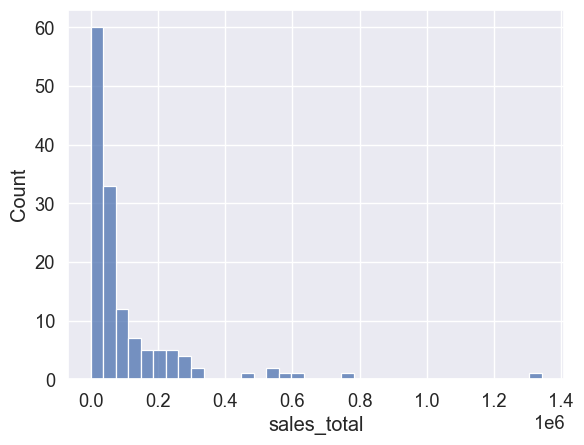

In [59]:
sns.set_theme(font_scale=1.2) # set theme for plots
sns.histplot(x=product_rfm["sales_total"]);

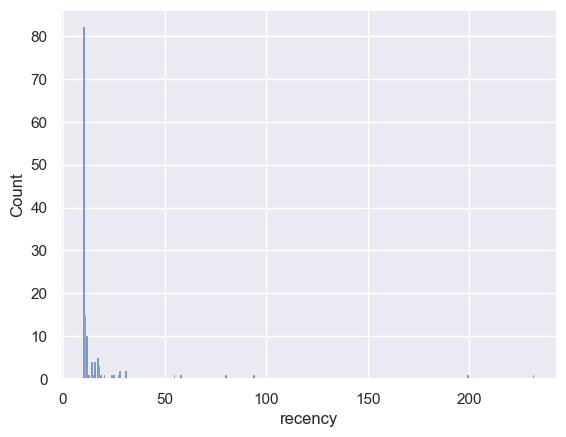

In [60]:
sns.set_theme(font_scale=1) # set theme for plots
sns.histplot(x=product_rfm["recency"]);

In [61]:
product_rfm["recency"].value_counts()

10     82
11     15
12     10
17      5
16      4
14      4
18      3
28      2
31      2
15      1
19      1
55      1
27      1
13      1
80      1
25      1
199     1
94      1
24      1
58      1
20      1
232     1
Name: recency, dtype: int64

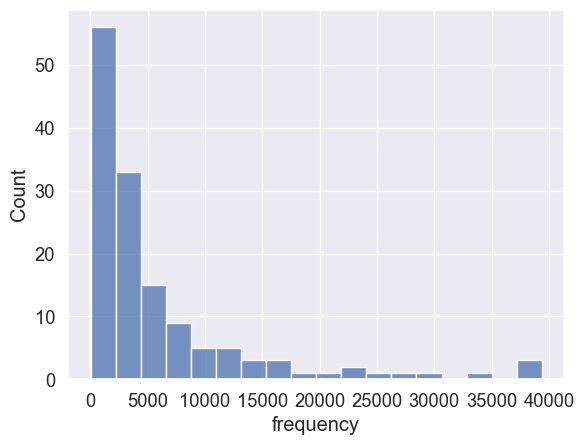

In [62]:
sns.set_theme(font_scale=1.2) # set theme for plots
sns.histplot(x=product_rfm["frequency"]);

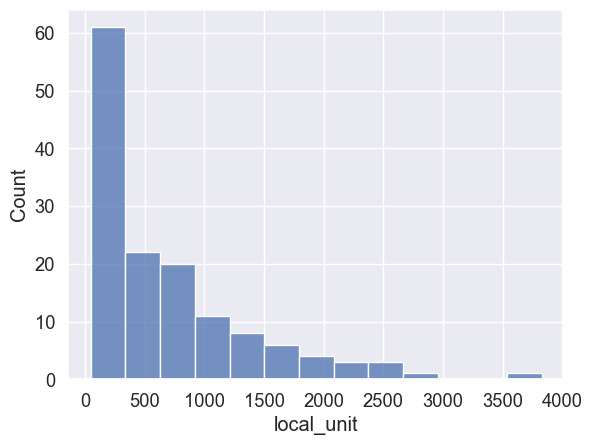

In [63]:
sns.set_theme(font_scale=1.2) # set theme for plots
sns.histplot(x=product_rfm["local_unit"]);

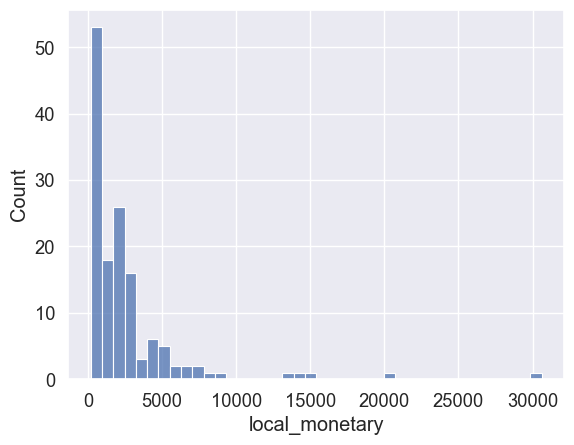

In [64]:
sns.set_theme(font_scale=1.2) # set theme for plots
sns.histplot(x=product_rfm["local_monetary"]);

In [65]:
product_rfm.columns

Index(['Product_Name', 'Product_Category', 'Store_Location', 'recency',
       'frequency', 'store_total', 'unit_total', 'sales_total', 'cost_total',
       'profit', 'profit_margin', 'unit_profit', 'local_monetary',
       'local_unit'],
      dtype='object')

In [66]:
rfm_beta = product_rfm[['recency','frequency','profit', 'profit_margin', 'unit_profit', 'local_monetary','local_unit']]

In [67]:
rfm_beta.head()

,recency,frequency,profit,profit_margin,unit_profit,local_monetary,local_unit
0,12,3656,26442,37.52,6.00,8814.00,1469.00
1,11,9185,64998,37.52,6.00,5416.50,902.75
2,10,29734,214296,37.52,6.00,7389.52,1231.59
3,10,5922,42012,37.52,6.00,7002.00,1167.00
4,20,2506,9642,23.10,3.00,3214.00,1071.33


In [68]:
rfm_beta.corr()

,recency,frequency,profit,profit_margin,unit_profit,local_monetary,local_unit
recency,1.00,-0.17,-0.13,0.21,0.23,-0.11,-0.19
frequency,-0.17,1.00,0.77,-0.05,-0.17,0.32,0.50
profit,-0.13,0.77,1.00,0.16,0.15,0.60,0.43
profit_margin,0.21,-0.05,0.16,1.00,0.67,0.22,-0.02
unit_profit,0.23,-0.17,0.15,0.67,1.00,0.20,-0.23
local_monetary,-0.11,0.32,0.60,0.22,0.20,1.00,0.73
local_unit,-0.19,0.50,0.43,-0.02,-0.23,0.73,1.00


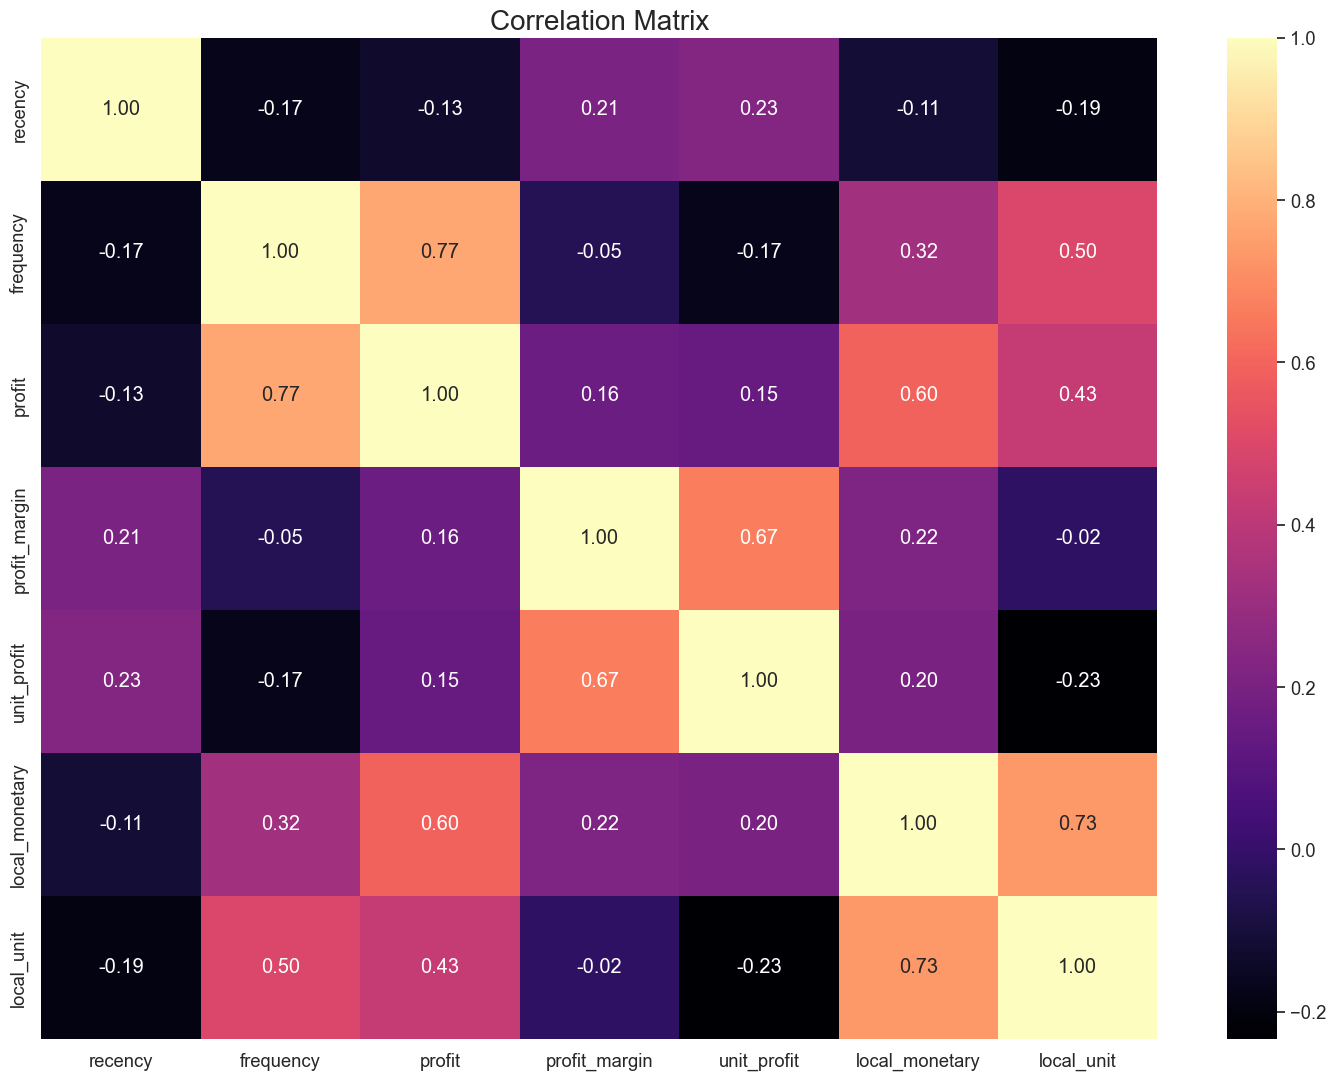

In [69]:
# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(rfm_beta.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

# Frequency ile profit (0,77) arasında, profit_margin ile unit_profit (0,67) arasında, local_monetary ile profit (0,6) arasında 
# ve local_unit ile local_monetary (0,73) arasında pozitif bir korelasyon var.

In [70]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
#from yellowbrick.cluster import KElbowVisualizer
#from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

scaler = MinMaxScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_beta))
rfm_normalized.columns = ['n_Recency', 'n_Frequency', 'n_Monetary', 'n_Margin', 'n_u_Monetary','n_loc_Monetary', 'n_loc_Unit']
rfm_normalized.describe()

,n_Recency,n_Frequency,n_Monetary,n_Margin,n_u_Monetary,n_loc_Monetary,n_loc_Unit
count,140.00,140.00,140.00,140.00,140.00,140.00,140.00
mean,0.03,0.15,0.07,0.38,0.23,0.08,0.17
std,0.12,0.20,0.12,0.27,0.21,0.12,0.18
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.03,0.01,0.18,0.07,0.02,0.03
50%,0.00,0.08,0.03,0.32,0.20,0.05,0.11
75%,0.01,0.18,0.07,0.63,0.33,0.08,0.24
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [71]:
rfm_normalized.head()

,n_Recency,n_Frequency,n_Monetary,n_Margin,n_u_Monetary,n_loc_Monetary,n_loc_Unit
0,0.01,0.09,0.06,0.47,0.33,0.28,0.38
1,0.00,0.23,0.16,0.47,0.33,0.17,0.23
2,0.00,0.76,0.52,0.47,0.33,0.24,0.31
3,0.00,0.15,0.10,0.47,0.33,0.22,0.30
4,0.05,0.06,0.02,0.23,0.13,0.10,0.27


In [72]:
rfm_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   n_Recency       140 non-null    float64
 1   n_Frequency     140 non-null    float64
 2   n_Monetary      140 non-null    float64
 3   n_Margin        140 non-null    float64
 4   n_u_Monetary    140 non-null    float64
 5   n_loc_Monetary  140 non-null    float64
 6   n_loc_Unit      140 non-null    float64
dtypes: float64(7)
memory usage: 7.8 KB


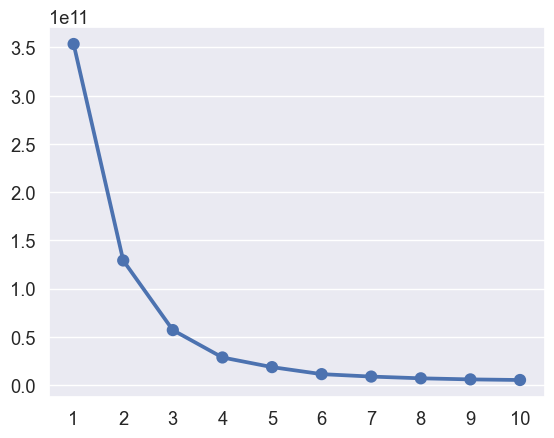

In [73]:
SSE = []
for k in range(0, 10):
    kmeans = KMeans(n_clusters=k+1, random_state=1231).fit(rfm_beta)
    SSE.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,11)), y=SSE)
plt.show()

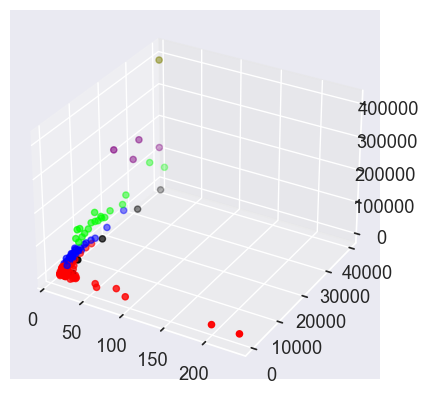

In [74]:
model = KMeans(n_clusters=5, random_state=1231).fit(rfm_beta)
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_beta['recency'],rfm_beta['frequency'],rfm_beta['profit'],cmap='brg',
          c=model.predict(rfm_beta))
ax.scatter(centers[:,0], centers[:,1],c='black');

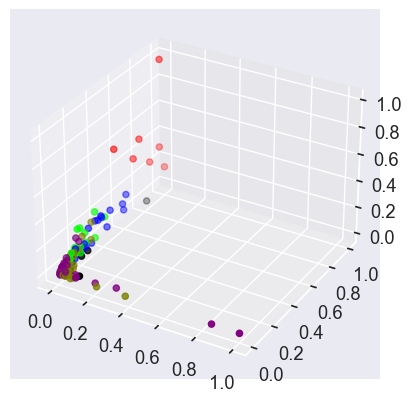

In [75]:
model = KMeans(n_clusters=5, random_state=1231).fit(rfm_normalized)
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_normalized['n_Recency'],rfm_normalized['n_Frequency'],rfm_normalized['n_Monetary'],cmap='brg',
          c=model.predict(rfm_normalized))
ax.scatter(centers[:,0], centers[:,1],c='black');

In [76]:
sales3 = sales1[['Sale_ID', 'Date','Product_ID', 'Units',
       'Product_Category', 'Store_Name',
       'Store_City', 'Store_Location', 'Store_Open_Date', 'sales', 'cost']]

In [77]:
sales3.head()

,Sale_ID,Date,Product_ID,Units,Product_Category,Store_Name,Store_City,Store_Location,Store_Open_Date,sales,cost
0,1,2017-01-01,4,1,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
1,66,2017-01-01,4,1,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
2,98,2017-01-01,4,1,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
3,128,2017-01-01,4,1,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
4,146,2017-01-01,4,1,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99


In [78]:
product_rfm = sales3.groupby(['Product_ID','Product_Category','Store_Location']).agg({'Date': lambda date: (today_date - date.max()).days,
                                     'Sale_ID': lambda Sale_ID: Sale_ID.nunique(),
                                     'Store_Open_Date': lambda Store_Open_Date: Store_Open_Date.nunique(),                                           
                                     'Units' : lambda Units: Units.sum(),
                                     'sales': lambda sales: sales.sum(),
                                     'cost': lambda cost: cost.sum()}).astype(int)

In [79]:
product_rfm.head()

Date  Sale_ID  Store_Open_Date  Units   sales    cost
Product_ID Product_Category Store_Location                                                       
1          Toys             Airport           12     3656                3   4407   70467   44025
                            Commercial        11     9185               12  10833  173219  108221
                            Downtown          10    29734               29  35716  571098  356802
                            Residential       10     5922                6   7002  111961   69949
2          Toys             Airport           20     2506                3   3214   41749   32107

In [80]:
product_rfm.reset_index(inplace=True)
product_rfm.columns = ["Product_Name", "Product_Category", "Store_Location", 'recency', 'frequency','store_total', 'unit_total', "sales_total", "cost_total"]

In [81]:
product_rfm.head()

,Product_Name,Product_Category,Store_Location,recency,frequency,store_total,unit_total,sales_total,cost_total
0,1,Toys,Airport,12,3656,3,4407,70467,44025
1,1,Toys,Commercial,11,9185,12,10833,173219,108221
2,1,Toys,Downtown,10,29734,29,35716,571098,356802
3,1,Toys,Residential,10,5922,6,7002,111961,69949
4,2,Toys,Airport,20,2506,3,3214,41749,32107


In [82]:
product_rfm['local_product_id'] = product_rfm["Product_Name"].astype(str) + product_rfm["Product_Category"].astype(str) + product_rfm["Store_Location"].astype(str)

In [83]:
product_rfm.head()

,Product_Name,Product_Category,Store_Location,recency,frequency,store_total,unit_total,sales_total,cost_total,local_product_id
0,1,Toys,Airport,12,3656,3,4407,70467,44025,1ToysAirport
1,1,Toys,Commercial,11,9185,12,10833,173219,108221,1ToysCommercial
2,1,Toys,Downtown,10,29734,29,35716,571098,356802,1ToysDowntown
3,1,Toys,Residential,10,5922,6,7002,111961,69949,1ToysResidential
4,2,Toys,Airport,20,2506,3,3214,41749,32107,2ToysAirport


In [84]:
product_rfm.index=product_rfm['local_product_id']
product_rfm.head()

,Product_Name,Product_Category,Store_Location,recency,frequency,store_total,unit_total,sales_total,cost_total,local_product_id
local_product_id,,,,,,,,,,
1ToysAirport,1,Toys,Airport,12,3656,3,4407,70467,44025,1ToysAirport
1ToysCommercial,1,Toys,Commercial,11,9185,12,10833,173219,108221,1ToysCommercial
1ToysDowntown,1,Toys,Downtown,10,29734,29,35716,571098,356802,1ToysDowntown
1ToysResidential,1,Toys,Residential,10,5922,6,7002,111961,69949,1ToysResidential
2ToysAirport,2,Toys,Airport,20,2506,3,3214,41749,32107,2ToysAirport


In [85]:
pro_rfm = product_rfm[['recency', 'frequency','store_total', 'unit_total', "sales_total", "cost_total"]]

In [86]:
pro_rfm.head()

,recency,frequency,store_total,unit_total,sales_total,cost_total
local_product_id,,,,,,
1ToysAirport,12,3656,3,4407,70467,44025
1ToysCommercial,11,9185,12,10833,173219,108221
1ToysDowntown,10,29734,29,35716,571098,356802
1ToysResidential,10,5922,6,7002,111961,69949
2ToysAirport,20,2506,3,3214,41749,32107


In [87]:
pro_rfm["profit"] = pro_rfm["sales_total"] - pro_rfm['cost_total']
pro_rfm["profit_margin"] = (pro_rfm["profit"] / pro_rfm['sales_total']) * 100
pro_rfm["unit_profit"] = pro_rfm["profit"] / pro_rfm['unit_total']
pro_rfm["local_monetary"] = pro_rfm["profit"] / pro_rfm['store_total']
pro_rfm["local_unit"] = pro_rfm["unit_total"] / pro_rfm['store_total']

In [88]:
pro_rfm.columns

Index(['recency', 'frequency', 'store_total', 'unit_total', 'sales_total', 'cost_total', 'profit', 'profit_margin', 'unit_profit', 'local_monetary', 'local_unit'], dtype='object')

In [89]:
pro_rfm_0 = pro_rfm[['recency', 'frequency','profit', 'profit_margin', 'unit_profit', 'local_monetary', 'local_unit']]

In [90]:
pro_rfm_0.head()

,recency,frequency,profit,profit_margin,unit_profit,local_monetary,local_unit
local_product_id,,,,,,,
1ToysAirport,12,3656,26442,37.52,6.00,8814.00,1469.00
1ToysCommercial,11,9185,64998,37.52,6.00,5416.50,902.75
1ToysDowntown,10,29734,214296,37.52,6.00,7389.52,1231.59
1ToysResidential,10,5922,42012,37.52,6.00,7002.00,1167.00
2ToysAirport,20,2506,9642,23.10,3.00,3214.00,1071.33


In [91]:
scaler = MinMaxScaler()
product_normalized = pd.DataFrame(scaler.fit_transform(pro_rfm_0))
product_normalized.columns = ['n_Recency', 'n_Frequency', 'n_Monetary', 'n_Margin', 'n_UnitMonetary','n_LocalMonetary', 'n_LocUnit']
product_normalized.describe()

,n_Recency,n_Frequency,n_Monetary,n_Margin,n_UnitMonetary,n_LocalMonetary,n_LocUnit
count,140.00,140.00,140.00,140.00,140.00,140.00,140.00
mean,0.03,0.15,0.07,0.38,0.23,0.08,0.17
std,0.12,0.20,0.12,0.27,0.21,0.12,0.18
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.03,0.01,0.18,0.07,0.02,0.03
50%,0.00,0.08,0.03,0.32,0.20,0.05,0.11
75%,0.01,0.18,0.07,0.63,0.33,0.08,0.24
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [92]:
product_normalized.head()

,n_Recency,n_Frequency,n_Monetary,n_Margin,n_UnitMonetary,n_LocalMonetary,n_LocUnit
0,0.01,0.09,0.06,0.47,0.33,0.28,0.38
1,0.00,0.23,0.16,0.47,0.33,0.17,0.23
2,0.00,0.76,0.52,0.47,0.33,0.24,0.31
3,0.00,0.15,0.10,0.47,0.33,0.22,0.30
4,0.05,0.06,0.02,0.23,0.13,0.10,0.27


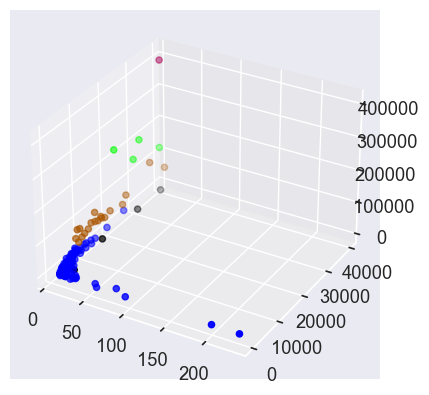

In [93]:
model = KMeans(n_clusters=4, random_state=1231).fit(pro_rfm_0)
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pro_rfm_0['recency'],pro_rfm_0['frequency'],pro_rfm_0['profit'],cmap='brg',
          c=model.predict(pro_rfm_0))
ax.scatter(centers[:,0], centers[:,1],c='black');

In [94]:
kmeans = KMeans(n_clusters=4).fit(pro_rfm_0)

In [95]:
pro_rfm_0["clusters"] = kmeans.labels_

In [96]:
pro_rfm_0.head()

,recency,frequency,profit,profit_margin,unit_profit,local_monetary,local_unit,clusters
local_product_id,,,,,,,,
1ToysAirport,12,3656,26442,37.52,6.00,8814.00,1469.00,0
1ToysCommercial,11,9185,64998,37.52,6.00,5416.50,902.75,2
1ToysDowntown,10,29734,214296,37.52,6.00,7389.52,1231.59,1
1ToysResidential,10,5922,42012,37.52,6.00,7002.00,1167.00,0
2ToysAirport,20,2506,9642,23.10,3.00,3214.00,1071.33,0


In [97]:
pro_rfm_0["clusters"].value_counts()

0    116
2     19
1      4
3      1
Name: clusters, dtype: int64

In [98]:
product_normalized["clusters"] = kmeans.labels_

In [99]:
product_normalized.head()

,n_Recency,n_Frequency,n_Monetary,n_Margin,n_UnitMonetary,n_LocalMonetary,n_LocUnit,clusters
0,0.01,0.09,0.06,0.47,0.33,0.28,0.38,0
1,0.00,0.23,0.16,0.47,0.33,0.17,0.23,2
2,0.00,0.76,0.52,0.47,0.33,0.24,0.31,1
3,0.00,0.15,0.10,0.47,0.33,0.22,0.30,0
4,0.05,0.06,0.02,0.23,0.13,0.10,0.27,0


In [100]:
product_normalized.index = pro_rfm_0.index

In [101]:
product_normalized.head()

,n_Recency,n_Frequency,n_Monetary,n_Margin,n_UnitMonetary,n_LocalMonetary,n_LocUnit,clusters
local_product_id,,,,,,,,
1ToysAirport,0.01,0.09,0.06,0.47,0.33,0.28,0.38,0
1ToysCommercial,0.00,0.23,0.16,0.47,0.33,0.17,0.23,2
1ToysDowntown,0.00,0.76,0.52,0.47,0.33,0.24,0.31,1
1ToysResidential,0.00,0.15,0.10,0.47,0.33,0.22,0.30,0
2ToysAirport,0.05,0.06,0.02,0.23,0.13,0.10,0.27,0


In [102]:
def value_unique(dataframe, col):
    print(dataframe[col].value_counts())

In [103]:
product_normalized.columns

Index(['n_Recency', 'n_Frequency', 'n_Monetary', 'n_Margin', 'n_UnitMonetary', 'n_LocalMonetary', 'n_LocUnit', 'clusters'], dtype='object')

In [104]:
col_list = ['n_Recency', 'n_Frequency', 'n_Monetary', 'n_Margin', 'n_UnitMonetary', 'n_LocalMonetary', 'n_LocUnit', 'clusters']

In [105]:
for col in col_list:
    print("-----------------")
    print(col,"-----------------")
    print("-----------------")
    print(value_unique(product_normalized,col))

-----------------
n_Recency -----------------
-----------------
0.00    82
0.00    15
0.01    10
0.03     5
0.03     4
0.02     4
0.04     3
0.08     2
0.09     2
0.02     1
0.04     1
0.20     1
0.08     1
0.01     1
0.32     1
0.07     1
0.85     1
0.38     1
0.06     1
0.22     1
0.05     1
1.00     1
Name: n_Recency, dtype: int64
None
-----------------
n_Frequency -----------------
-----------------
0.10    2
0.07    2
0.07    1
0.04    1
0.11    1
       ..
0.05    1
0.03    1
0.09    1
0.36    1
0.01    1
Name: n_Frequency, Length: 138, dtype: int64
None
-----------------
n_Monetary -----------------
-----------------
0.06    1
0.02    1
0.06    1
0.01    1
0.04    1
       ..
0.03    1
0.04    1
0.16    1
0.06    1
0.00    1
Name: n_Monetary, Length: 140, dtype: int64
None
-----------------
n_Margin -----------------
-----------------
0.47    1
0.40    1
0.67    1
0.67    1
0.26    1
       ..
0.63    1
0.29    1
0.29    1
0.29    1
0.67    1
Name: n_Margin, Length: 140, dtype: 

In [106]:
product_normalized.corr()

,n_Recency,n_Frequency,n_Monetary,n_Margin,n_UnitMonetary,n_LocalMonetary,n_LocUnit,clusters
n_Recency,1.00,-0.17,-0.13,0.21,0.23,-0.11,-0.19,-0.11
n_Frequency,-0.17,1.00,0.77,-0.05,-0.17,0.32,0.50,0.69
n_Monetary,-0.13,0.77,1.00,0.16,0.15,0.60,0.43,0.69
n_Margin,0.21,-0.05,0.16,1.00,0.67,0.22,-0.02,0.10
n_UnitMonetary,0.23,-0.17,0.15,0.67,1.00,0.20,-0.23,0.07
n_LocalMonetary,-0.11,0.32,0.60,0.22,0.20,1.00,0.73,0.41
n_LocUnit,-0.19,0.50,0.43,-0.02,-0.23,0.73,1.00,0.32
clusters,-0.11,0.69,0.69,0.10,0.07,0.41,0.32,1.00


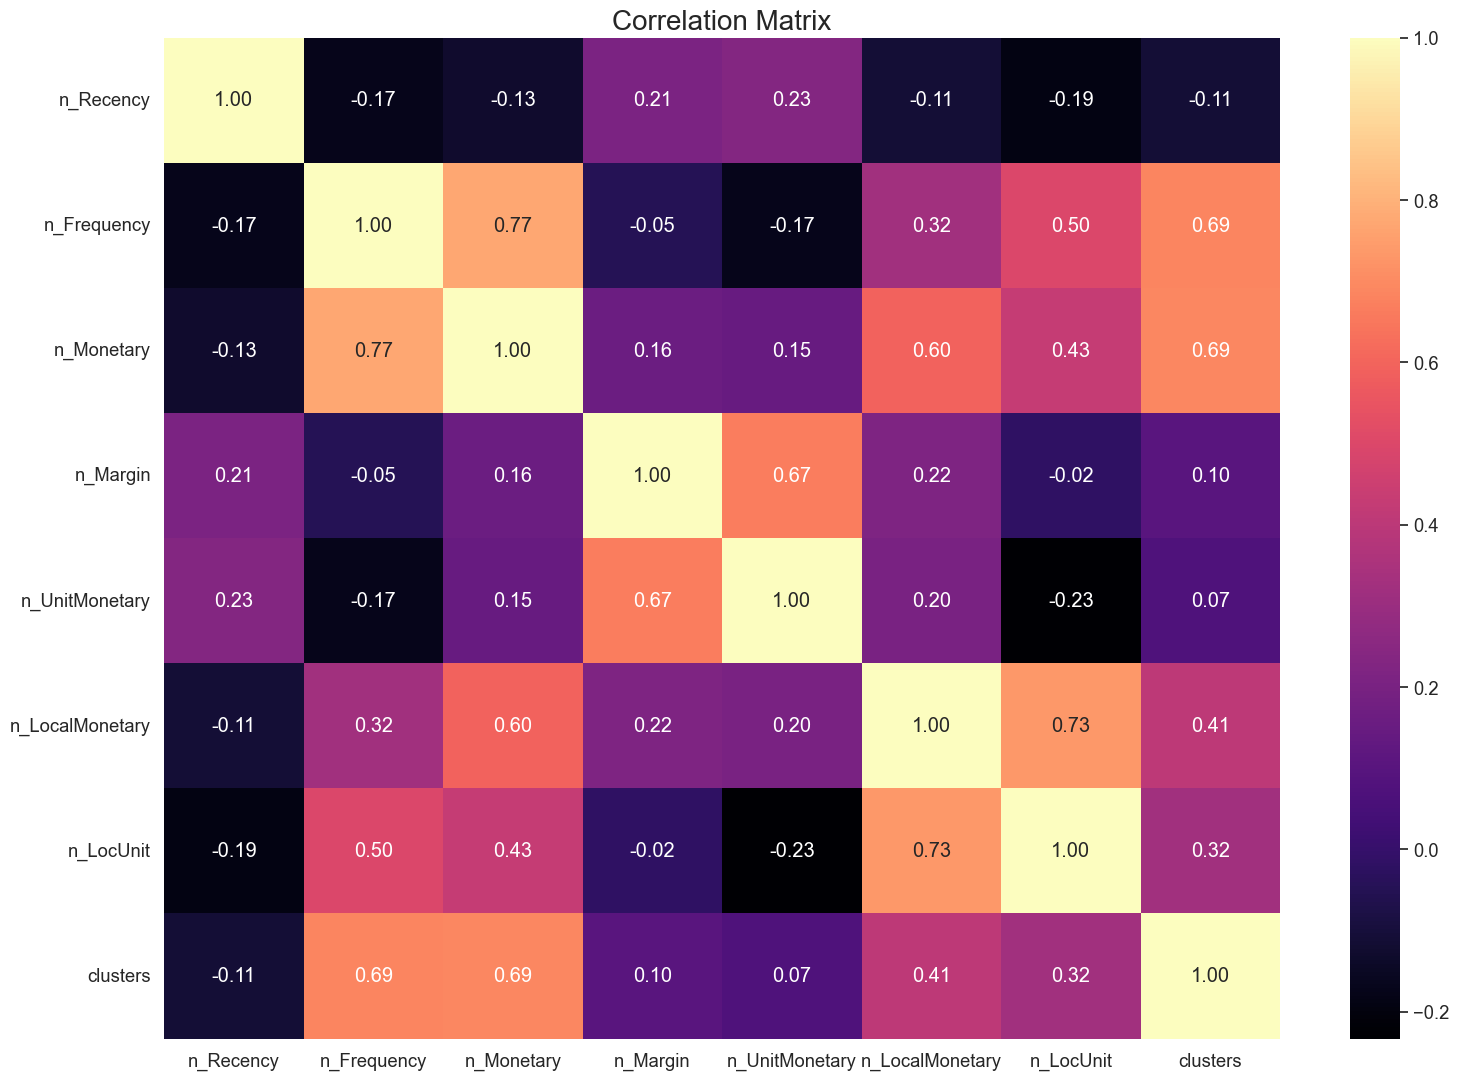

In [107]:
# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(product_normalized.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [108]:
product_normalized.describe()

,n_Recency,n_Frequency,n_Monetary,n_Margin,n_UnitMonetary,n_LocalMonetary,n_LocUnit,clusters
count,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00
mean,0.03,0.15,0.07,0.38,0.23,0.08,0.17,0.32
std,0.12,0.20,0.12,0.27,0.21,0.12,0.18,0.73
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.03,0.01,0.18,0.07,0.02,0.03,0.00
50%,0.00,0.08,0.03,0.32,0.20,0.05,0.11,0.00
75%,0.01,0.18,0.07,0.63,0.33,0.08,0.24,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,3.00


In [109]:
product_normalized[product_normalized["clusters"] == 0].describe()

,n_Recency,n_Frequency,n_Monetary,n_Margin,n_UnitMonetary,n_LocalMonetary,n_LocUnit,clusters
count,116.00,116.00,116.00,116.00,116.00,116.00,116.00,116.00
mean,0.04,0.08,0.03,0.37,0.23,0.06,0.14,0.00
std,0.13,0.09,0.03,0.28,0.22,0.07,0.16,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.02,0.01,0.18,0.07,0.01,0.02,0.00
50%,0.00,0.06,0.02,0.29,0.20,0.03,0.08,0.00
75%,0.02,0.10,0.04,0.61,0.33,0.07,0.20,0.00
max,1.00,0.60,0.10,1.00,1.00,0.43,0.70,0.00


In [110]:
pro_rfm_0[pro_rfm_0["clusters"] == 0].describe()

,recency,frequency,profit,profit_margin,unit_profit,local_monetary,local_unit,clusters
count,116.00,116.00,116.00,116.00,116.00,116.00,116.00,116.00
mean,18.11,3280.63,12535.03,31.56,4.41,1865.29,579.68,0.00
std,29.01,3554.29,10450.49,16.85,3.27,2020.81,608.00,0.00
min,10.00,47.00,188.00,9.10,1.00,188.00,47.00,0.00
25%,10.00,857.00,4216.75,20.01,2.00,565.38,139.22,0.00
50%,10.00,2349.00,9348.00,26.68,4.00,1196.49,340.90,0.00
75%,14.00,4154.75,18504.50,46.03,6.00,2426.96,803.42,0.00
max,232.00,23557.00,42012.00,70.07,16.00,13215.00,2704.67,0.00


In [111]:
product_normalized[product_normalized["clusters"] == 1].describe()

,n_Recency,n_Frequency,n_Monetary,n_Margin,n_UnitMonetary,n_LocalMonetary,n_LocUnit,clusters
count,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00
mean,0.00,0.73,0.47,0.45,0.30,0.31,0.42,1.00
std,0.00,0.18,0.11,0.28,0.14,0.24,0.17,0.00
min,0.00,0.52,0.34,0.06,0.13,0.15,0.29,1.00
25%,0.00,0.65,0.39,0.36,0.23,0.18,0.31,1.00
50%,0.00,0.73,0.47,0.51,0.30,0.21,0.36,1.00
75%,0.00,0.80,0.54,0.60,0.37,0.34,0.47,1.00
max,0.00,0.95,0.59,0.73,0.47,0.66,0.66,1.00


In [112]:
pro_rfm_0[pro_rfm_0["clusters"] == 1].describe()

,recency,frequency,profit,profit_margin,unit_profit,local_monetary,local_unit,clusters
count,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00
mean,10.00,28779.50,191268.00,36.58,5.50,9574.84,1632.02,1.00
std,0.00,6981.89,46855.51,17.35,2.08,7249.39,636.07,0.00
min,10.00,20492.00,139041.00,12.50,3.00,4794.52,1157.07,1.00
25%,10.00,25716.50,160591.50,31.27,4.50,5537.64,1212.96,1.00
50%,10.00,28596.00,191035.50,40.22,5.50,6587.43,1414.88,1.00
75%,10.00,31659.00,221712.00,45.53,6.50,10624.64,1833.94,1.00
max,10.00,37434.00,243960.00,53.37,8.00,20330.00,2541.25,1.00


In [113]:
product_normalized[product_normalized["clusters"] == 2].describe()

,n_Recency,n_Frequency,n_Monetary,n_Margin,n_UnitMonetary,n_LocalMonetary,n_LocUnit,clusters
count,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00
mean,0.00,0.39,0.18,0.42,0.25,0.16,0.28,2.00
std,0.00,0.23,0.04,0.26,0.16,0.23,0.23,0.00
min,0.00,0.16,0.13,0.01,0.00,0.05,0.05,2.00
25%,0.00,0.22,0.15,0.26,0.13,0.07,0.13,2.00
50%,0.00,0.33,0.16,0.34,0.27,0.08,0.19,2.00
75%,0.00,0.45,0.19,0.61,0.33,0.14,0.38,2.00
max,0.00,1.00,0.28,1.00,0.60,1.00,1.00,2.00


In [114]:
pro_rfm_0[pro_rfm_0["clusters"] == 2].describe()

,recency,frequency,profit,profit_margin,unit_profit,local_monetary,local_unit,clusters
count,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00
mean,10.11,15571.74,72873.53,34.60,4.74,5067.21,1102.86,2.00
std,0.32,9049.75,16324.93,16.00,2.42,6853.05,883.31,0.00
min,10.00,6369.00,53046.00,10.01,1.00,1829.17,236.34,2.00
25%,10.00,8846.50,63674.50,25.01,3.00,2297.38,539.55,2.00
50%,10.00,13186.00,67248.00,30.03,5.00,2517.38,770.24,2.00
75%,10.00,17641.50,76741.00,46.57,6.00,4497.84,1480.55,2.00
max,11.00,39356.00,116230.00,70.07,10.00,30618.67,3827.33,2.00


In [115]:
product_normalized[product_normalized["clusters"] == 3].describe()

,n_Recency,n_Frequency,n_Monetary,n_Margin,n_UnitMonetary,n_LocalMonetary,n_LocUnit,clusters
count,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
mean,0.00,0.96,1.00,0.73,0.47,0.46,0.46,3.00
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.00,0.96,1.00,0.73,0.47,0.46,0.46,3.00
25%,0.00,0.96,1.00,0.73,0.47,0.46,0.46,3.00
50%,0.00,0.96,1.00,0.73,0.47,0.46,0.46,3.00
75%,0.00,0.96,1.00,0.73,0.47,0.46,0.46,3.00
max,0.00,0.96,1.00,0.73,0.47,0.46,0.46,3.00


In [116]:
pro_rfm_0[pro_rfm_0["clusters"] == 3].describe()

,recency,frequency,profit,profit_margin,unit_profit,local_monetary,local_unit,clusters
count,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
mean,10.00,37728.00,410296.00,53.37,8.00,14148.14,1768.52,3.00
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,10.00,37728.00,410296.00,53.37,8.00,14148.14,1768.52,3.00
25%,10.00,37728.00,410296.00,53.37,8.00,14148.14,1768.52,3.00
50%,10.00,37728.00,410296.00,53.37,8.00,14148.14,1768.52,3.00
75%,10.00,37728.00,410296.00,53.37,8.00,14148.14,1768.52,3.00
max,10.00,37728.00,410296.00,53.37,8.00,14148.14,1768.52,3.00


In [117]:
pro_rfm_0[pro_rfm_0["clusters"] == 3]

,recency,frequency,profit,profit_margin,unit_profit,local_monetary,local_unit,clusters
local_product_id,,,,,,,,
6ElectronicsDowntown,10,37728,410296,53.37,8.00,14148.14,1768.52,3


In [118]:
product_rfm[product_rfm["Product_Name"] == 6]

,Product_Name,Product_Category,Store_Location,recency,frequency,store_total,unit_total,sales_total,cost_total,local_product_id
local_product_id,,,,,,,,,,
6ElectronicsAirport,6,Electronics,Airport,10,6934,3,11482,172115,80259,6ElectronicsAirport
6ElectronicsCommercial,6,Electronics,Commercial,10,20492,12,30495,457120,213160,6ElectronicsCommercial
6ElectronicsDowntown,6,Electronics,Downtown,10,37728,29,51287,768792,358496,6ElectronicsDowntown
6ElectronicsResidential,6,Electronics,Residential,10,7834,6,11104,166448,77616,6ElectronicsResidential


In [119]:
pro_rfm[pro_rfm.index.str.startswith('6')]

,recency,frequency,store_total,unit_total,sales_total,cost_total,profit,profit_margin,unit_profit,local_monetary,local_unit
local_product_id,,,,,,,,,,,
6ElectronicsAirport,10,6934,3,11482,172115,80259,91856,53.37,8.00,30618.67,3827.33
6ElectronicsCommercial,10,20492,12,30495,457120,213160,243960,53.37,8.00,20330.00,2541.25
6ElectronicsDowntown,10,37728,29,51287,768792,358496,410296,53.37,8.00,14148.14,1768.52
6ElectronicsResidential,10,7834,6,11104,166448,77616,88832,53.37,8.00,14805.33,1850.67


In [120]:
sales1.head()

,Sale_ID,Date,Store_ID,Product_ID,Units,Product_Name,Product_Category,Product_Cost,Product_Price,Store_Name,Store_City,Store_Location,Store_Open_Date,sales,cost
0,1,2017-01-01,24,4,1,Chutes & Ladders,Games,9.99,12.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
1,66,2017-01-01,24,4,1,Chutes & Ladders,Games,9.99,12.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
2,98,2017-01-01,24,4,1,Chutes & Ladders,Games,9.99,12.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
3,128,2017-01-01,24,4,1,Chutes & Ladders,Games,9.99,12.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
4,146,2017-01-01,24,4,1,Chutes & Ladders,Games,9.99,12.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99


In [121]:
sales1[sales1["Product_ID"] == 6].head()

,Sale_ID,Date,Store_ID,Product_ID,Units,Product_Name,Product_Category,Product_Cost,Product_Price,Store_Name,Store_City,Store_Location,Store_Open_Date,sales,cost
6891,2815,2017-01-04,24,6,3,Colorbuds,Electronics,6.99,14.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,44.97,20.97
6892,2816,2017-01-04,24,6,2,Colorbuds,Electronics,6.99,14.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,29.98,13.98
6893,2978,2017-01-04,24,6,3,Colorbuds,Electronics,6.99,14.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,44.97,20.97
6894,3044,2017-01-04,24,6,3,Colorbuds,Electronics,6.99,14.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,44.97,20.97
6895,3066,2017-01-04,24,6,3,Colorbuds,Electronics,6.99,14.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,44.97,20.97


In [122]:
sales_product.head()

,Product_Name,Product_Category,Store_Location,date_min,date_max,unit_sum,sales_sum,cost_sum,frequency,profit,profit_margin,unit_profit,tenure,recency
0,Action Figure,Toys,Airport,2017-01-01,2018-09-28,4407,70467.93,44025.93,3656,26442.00,37.52,6.00,635 days,12 days
1,Action Figure,Toys,Commercial,2017-01-02,2018-09-29,10833,173219.67,108221.67,9185,64998.00,37.52,6.00,635 days,11 days
2,Action Figure,Toys,Downtown,2017-01-01,2018-09-30,35716,571098.84,356802.84,29734,214296.00,37.52,6.00,637 days,10 days
3,Action Figure,Toys,Residential,2017-01-02,2018-09-30,7002,111961.98,69949.98,5922,42012.00,37.52,6.00,636 days,10 days
4,Animal Figures,Toys,Airport,2017-01-01,2018-09-20,3214,41749.86,32107.86,2506,9642.00,23.09,3.00,627 days,20 days


In [123]:
sales_product[sales_product["Product_Name"] == "Colorbuds"]

,Product_Name,Product_Category,Store_Location,date_min,date_max,unit_sum,sales_sum,cost_sum,frequency,profit,profit_margin,unit_profit,tenure,recency
20,Colorbuds,Electronics,Airport,2017-01-01,2018-09-30,11482,172115.18,80259.18,6934,91856.00,53.37,8.00,637 days,10 days
21,Colorbuds,Electronics,Commercial,2017-01-01,2018-09-30,30495,457120.05,213160.05,20492,243960.00,53.37,8.00,637 days,10 days
22,Colorbuds,Electronics,Downtown,2017-01-01,2018-09-30,51287,768792.13,358496.13,37728,410296.00,53.37,8.00,637 days,10 days
23,Colorbuds,Electronics,Residential,2017-01-01,2018-09-30,11104,166448.96,77616.96,7834,88832.00,53.37,8.00,637 days,10 days


### 5 - Sales Graph over period in the given Datasets

In [127]:
sales4 = sales2.copy()

In [129]:
sales4.head()

,Sale_ID,Date,Units,Product_Name,Product_Category,Store_Name,Store_City,Store_Location,Store_Open_Date,sales,cost
0,1,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
1,66,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
2,98,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
3,128,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99
4,146,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99


In [130]:
sales4["profit"] = sales4["sales"] - sales4['cost']
sales4["profit_margin"] = (sales4["profit"] / sales4['sales']) * 100

In [132]:
sales4.head()

,Sale_ID,Date,Units,Product_Name,Product_Category,Store_Name,Store_City,Store_Location,Store_Open_Date,sales,cost,profit,profit_margin
0,1,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99,3.00,23.09
1,66,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99,3.00,23.09
2,98,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99,3.00,23.09
3,128,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99,3.00,23.09
4,146,2017-01-01,1,Chutes & Ladders,Games,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,12.99,9.99,3.00,23.09


In [131]:
sales_daily = sales4.groupby('Date').sales.sum()
sales_daily_df = pd.DataFrame(sales_daily)
sales_weekly_mean = sales_daily_df['sales'].resample('W').mean()
sales_monthly_mean = sales_daily_df['sales'].resample('M').mean()

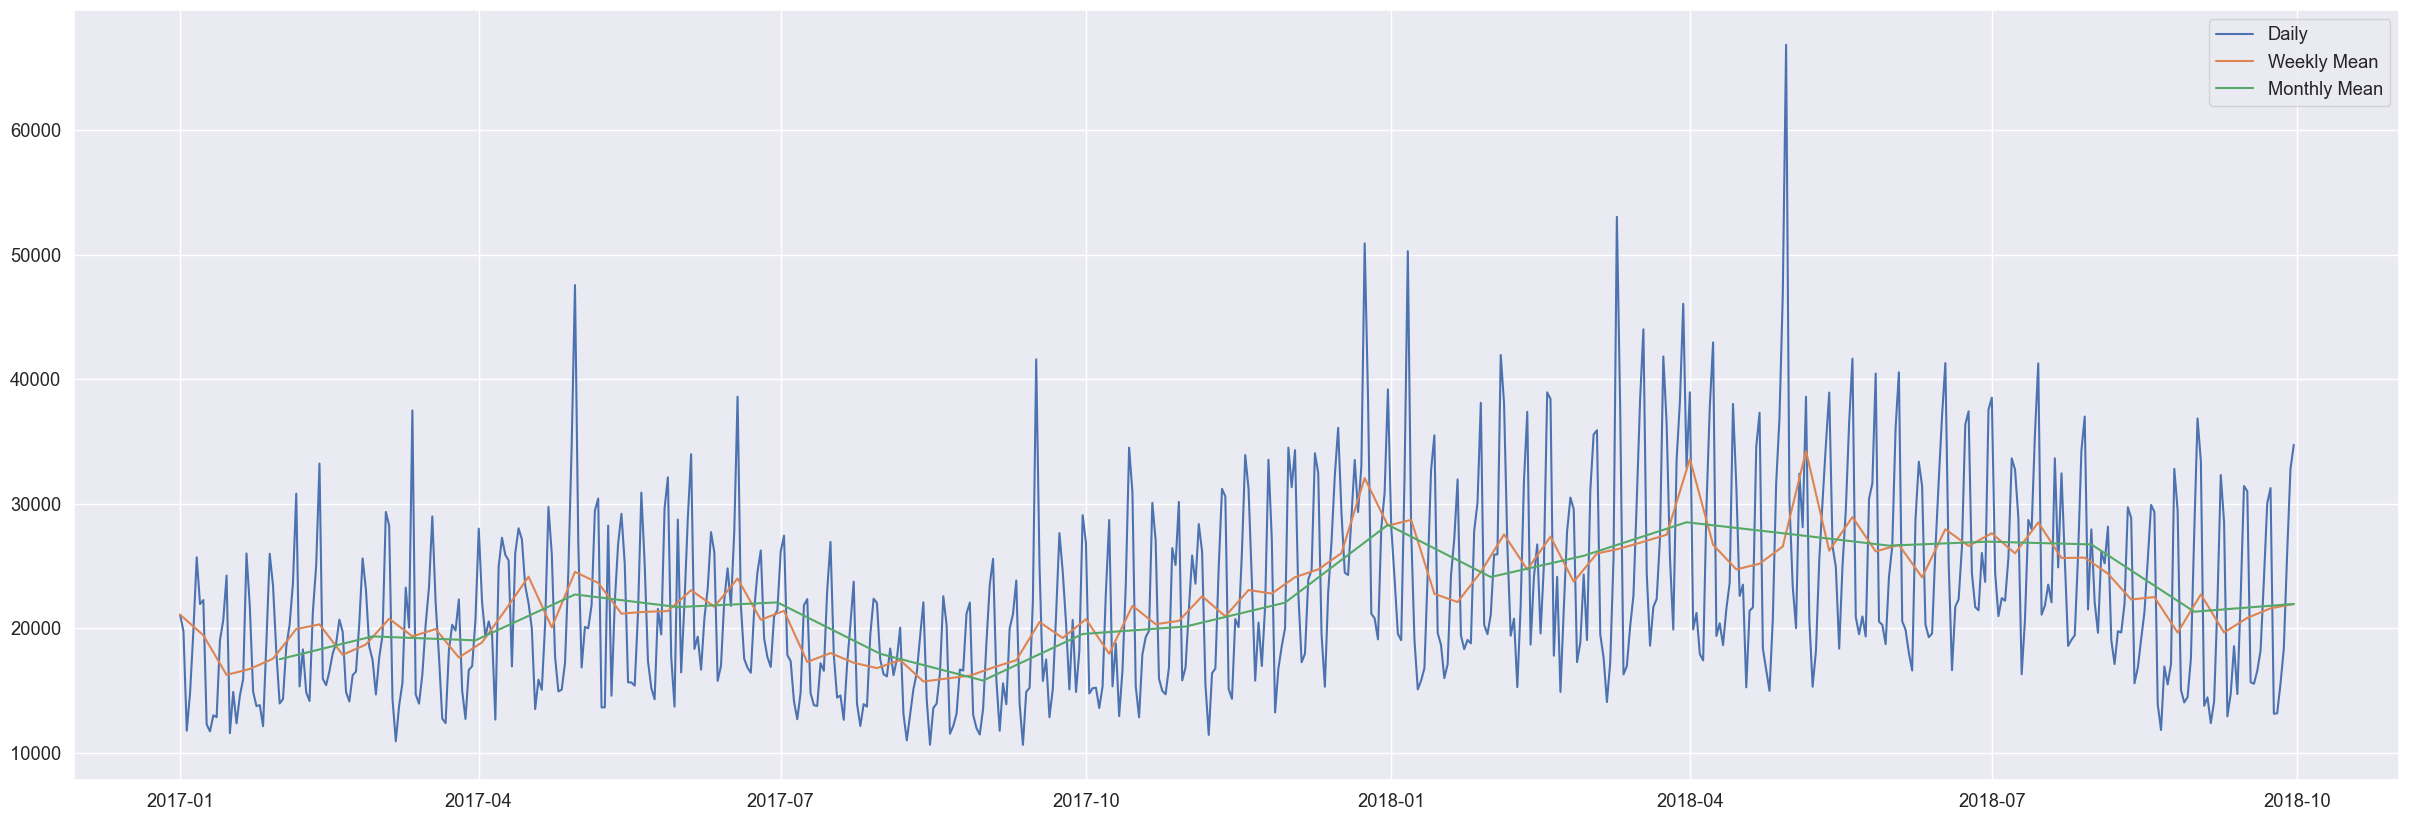

In [125]:
plt.figure(figsize=(30, 10))
plt.plot(sales_daily, label='Daily')
plt.plot(sales_weekly_mean, label='Weekly Mean')
plt.plot(sales_monthly_mean, label='Monthly Mean')
plt.legend()
plt.show()

In [136]:
profit_daily = sales4.groupby('Date').profit.sum()
profit_daily_df = pd.DataFrame(profit_daily)
profit_weekly_mean = profit_daily_df['profit'].resample('W').mean()
profit_monthly_mean = profit_daily_df['profit'].resample('M').mean()

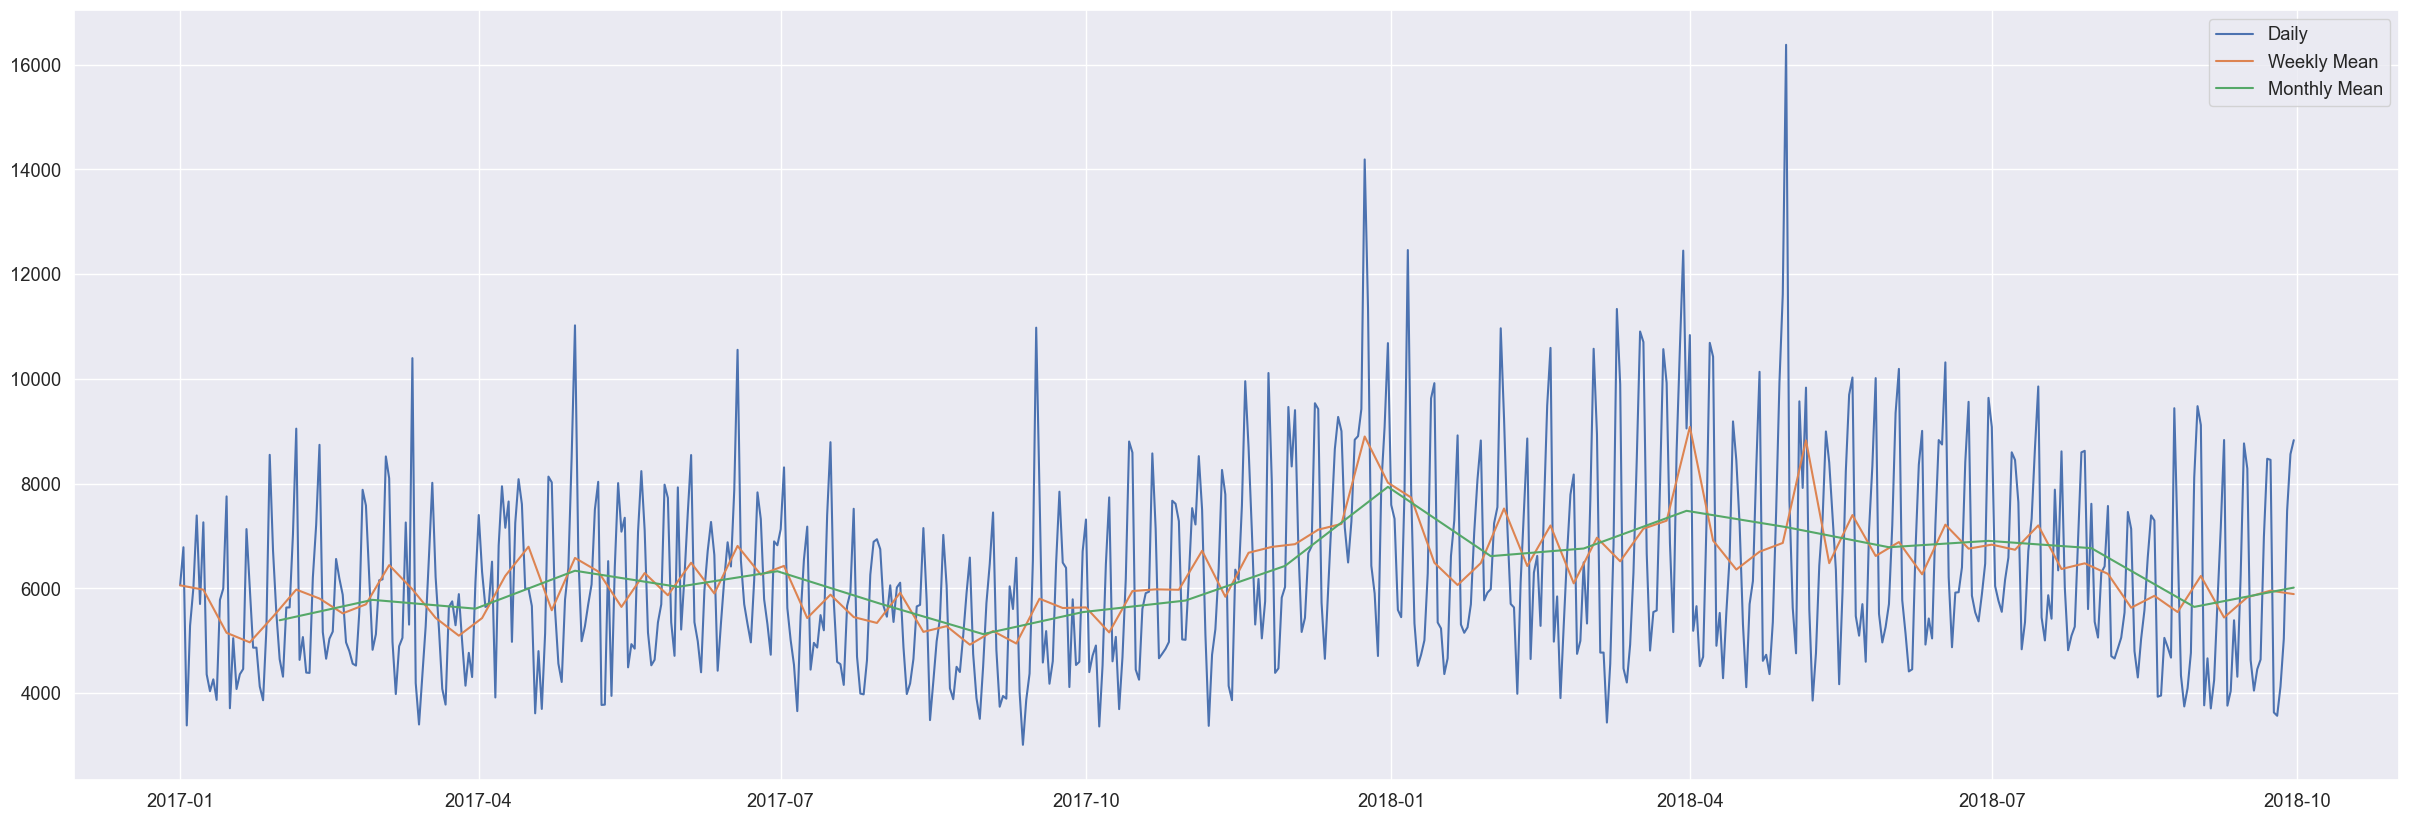

In [137]:
plt.figure(figsize=(30, 10))
plt.plot(profit_daily, label='Daily')
plt.plot(profit_weekly_mean, label='Weekly Mean')
plt.plot(profit_monthly_mean, label='Monthly Mean')
plt.legend()
plt.show()

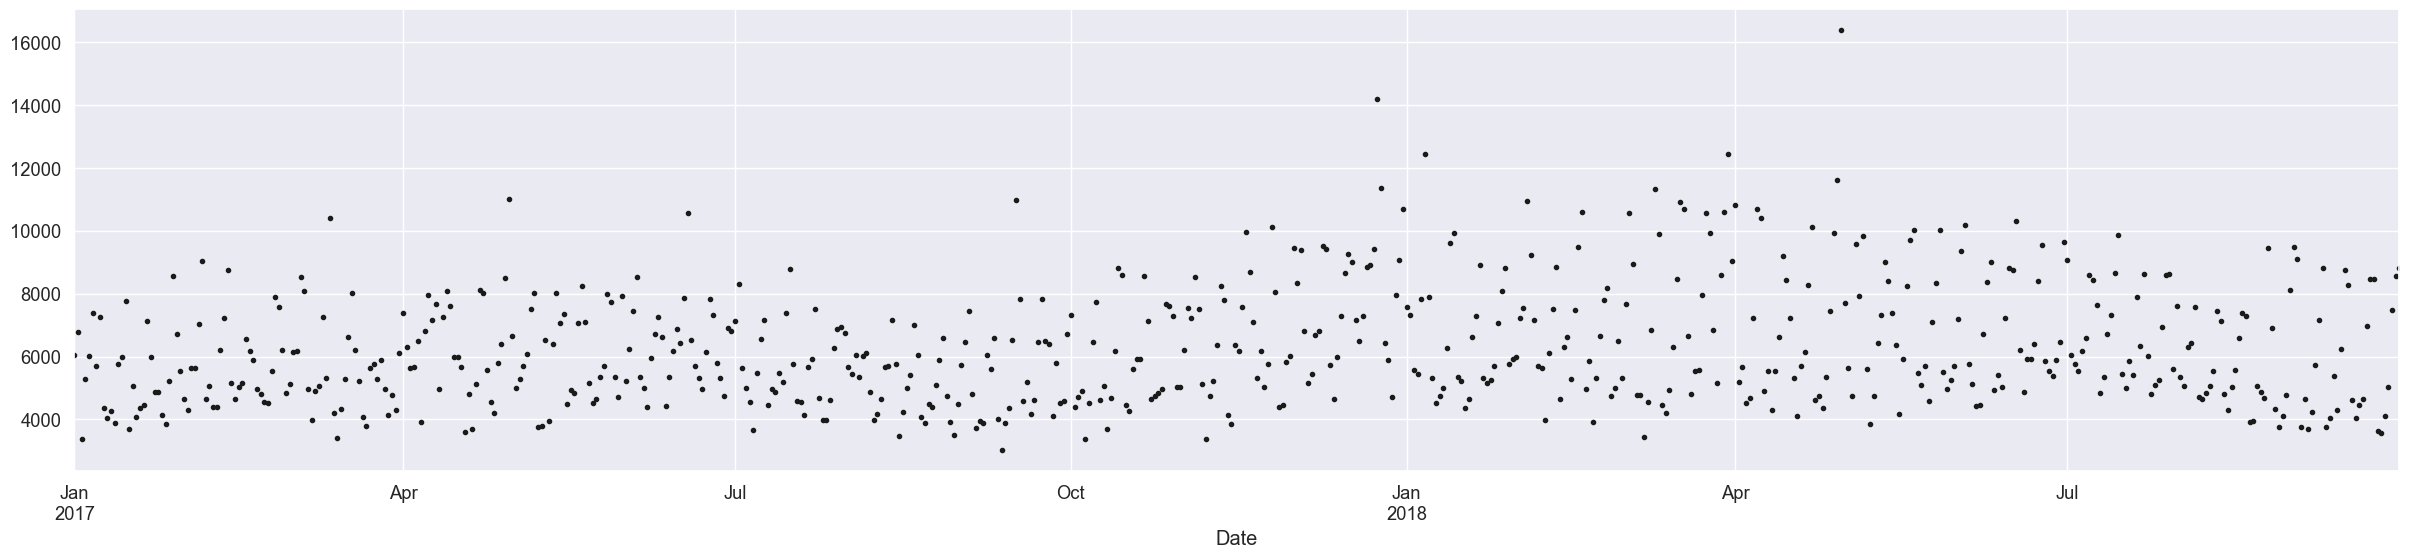

In [138]:
sales_daily.plot(style='k.', figsize=(30, 6))
plt.show()

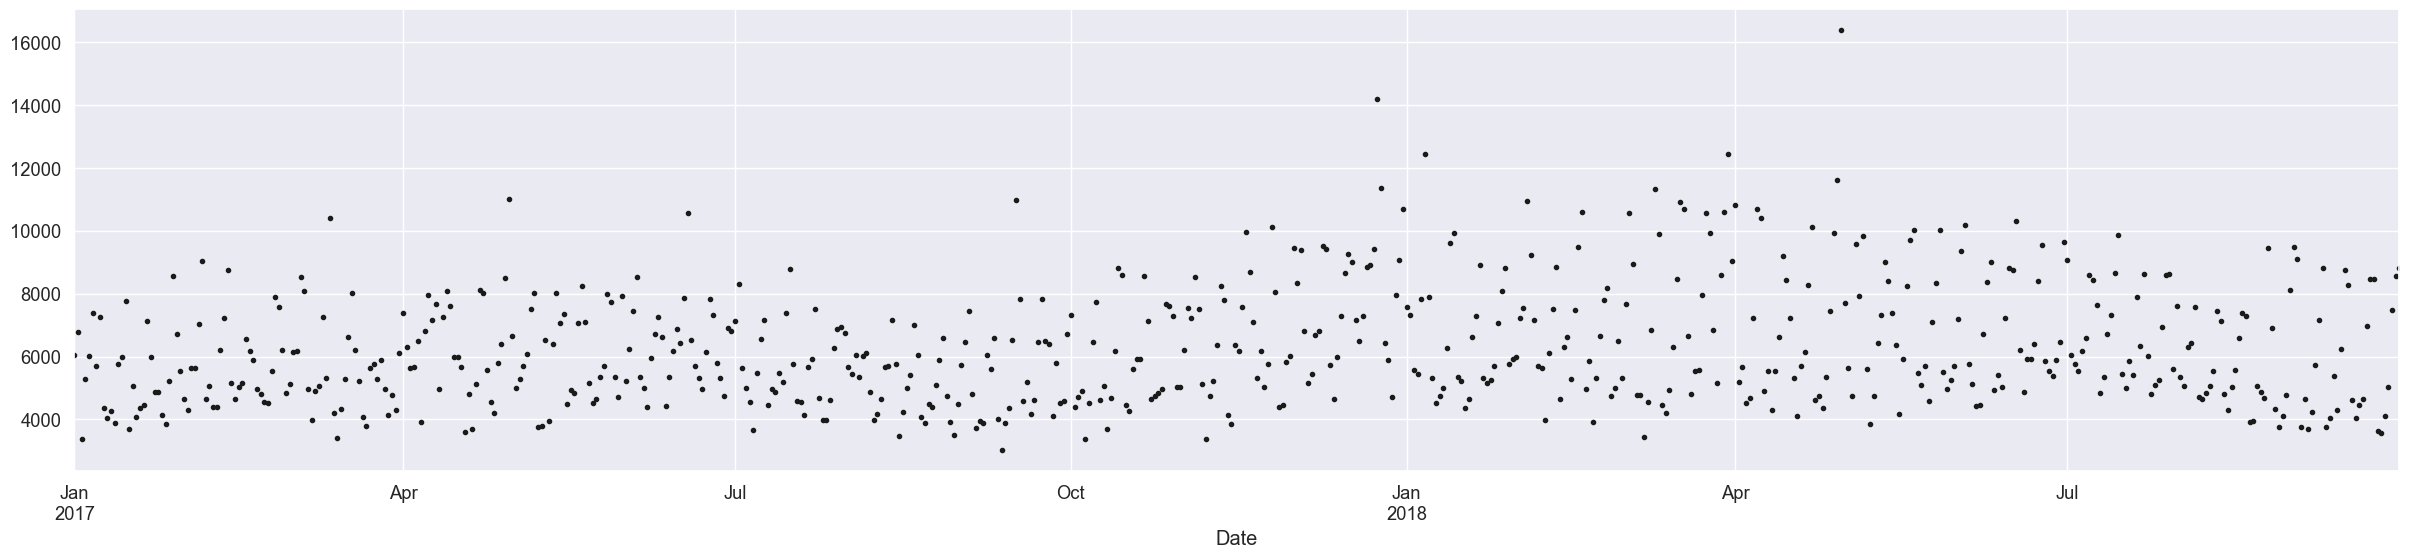

In [139]:
profit_daily.plot(style='k.', figsize=(30, 6))
plt.show()

### 6 - Possible Pattern
#### Now we are looking for possible pattern in time analysis.

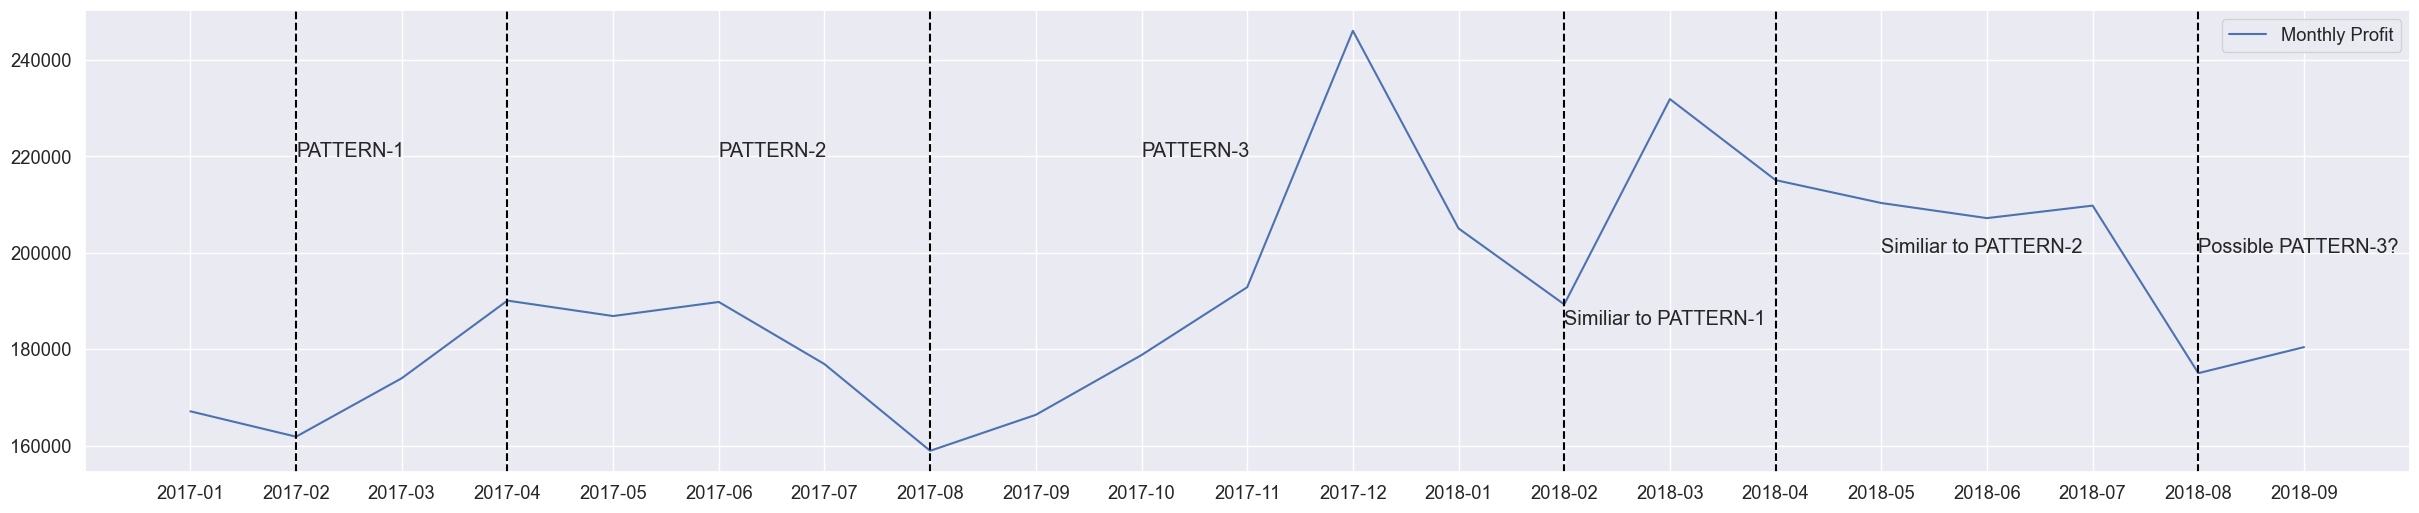

In [146]:
profit_monthly = sales4.groupby([sales4['Date'].dt.year.rename('year'), sales4['Date'].dt.to_period("M").rename('month')])['profit'].sum().reset_index()
profit_monthly['month'] = profit_monthly['month'].astype(str)

plt.figure(figsize=(30, 6))
plt.plot(profit_monthly['month'],profit_monthly['profit'], label='Monthly Profit')
plt.legend()

xcoords = ['2017-04', '2018-04','2017-02', '2018-02', '2017-08', '2018-08']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
    
plt.annotate('PATTERN-1', ('2017-02', 220000))
plt.annotate('PATTERN-2', ('2017-06', 220000))
plt.annotate('PATTERN-3', ('2017-10', 220000))

plt.annotate('Similiar to PATTERN-1', ('2018-02', 185000))
plt.annotate('Similiar to PATTERN-2', ('2018-05', 200000))
plt.annotate('Possible PATTERN-3?', ('2018-08', 200000))

plt.show()

### 7- Building a Model

In [147]:
profit_weekly = pd.DataFrame(sales4.groupby([sales4['Date'].dt.year.rename('year'), sales4['Date'].dt.to_period("W").rename('week')])['profit'].sum().reset_index().drop('year', axis=1).set_index('week'))
profit_weekly

,profit
week,
2016-12-26/2017-01-01,6058.00
2017-01-02/2017-01-08,41825.00
2017-01-09/2017-01-15,36061.00
2017-01-16/2017-01-22,34786.00
2017-01-23/2017-01-29,38220.00
...,...
2018-08-27/2018-09-02,43660.00
2018-09-03/2018-09-09,38103.00
2018-09-10/2018-09-16,40814.00


In [148]:
arima_model=auto_arima(profit_weekly['profit'], start_p=1,d=1,start_q=1,
                      max_p=5,max_q=5,max_d=5,m=12,
                        start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,
                      seasonal=True,
                       trace=True,
                      error_action="ignore",
                      suppress_warnings=True,
                      stepwise=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1651.566, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1670.770, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1619.390, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1653.536, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1610.362, Time=0.32 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1600.654, Time=1.51 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1608.551, Time=1.40 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=1608.721, Time=1.01 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1607.556, Time=0.44 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=5.38 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=1611.280, Time=0.37 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=1608.722, Time=0.76 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=1607.704, Time=1.02 sec
 ARIMA(0,1,1)(3,1,0)[12]     

In [149]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 12)   Log Likelihood                -794.790
Date:                             Fri, 06 Oct 2023   AIC                           1599.580
Time:                                     10:15:28   BIC                           1611.427
Sample:                                 01-01-2017   HQIC                          1604.327
                                      - 09-30-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4212      0.104     -4.060      0.000      -0.625      -0.218
ar.S.L12      -0.8679      0.094     -9.264      0.000      -1.052      -0.684
ar.S.L24      -0.6819      0.103     -6.639      0.000      -0.883      -0.481
ar.S.L36      -0.3950      0.059     -6.749      0.000      -0.510      -0.280
sigma2      2.988e+07   1.78e-09   1.68e+16      0.000    2.99e+07    2.99e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.33   Prob(JB):                         0.58
Heteroskedasticity (H):               0.83   Skew:                             0.06
Prob(H) (two-sided):                  0.63   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.39e+31. Standard errors may be unstable.
"""

In [150]:
size=int(len(profit_weekly)*0.66)
X_train,X_test=profit_weekly[0:size],profit_weekly[size:len(profit_weekly)]

model=SARIMAX(profit_weekly['profit'],
             order=(0,1,1),
             seasonal_order=(3,1,0,12))
result=model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74546D+00    |proj g|=  1.69887D-01



 This problem is unconstrained.


At iterate    5    f=  8.69670D+00    |proj g|=  1.05277D-04

At iterate   10    f=  8.69670D+00    |proj g|=  5.76902D-04

At iterate   15    f=  8.69649D+00    |proj g|=  7.83247D-03

At iterate   20    f=  8.67907D+00    |proj g|=  7.26925D-02

At iterate   25    f=  8.63902D+00    |proj g|=  6.07553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   5.637D-06   8.639D+00
  F =   8.6390231195209193     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              profit   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 12)   Log Likelihood                -794.790
Date:                             Fri, 06 Oct 2023   AIC                           1599.580
Time:                                     10:16:58   BIC                           1611.427
Sample:                                 01-01-2017   HQIC                          1604.327
                                      - 09-30-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4212      0.104     -4.060      0.000      -0.625      -0.218
ar.S.L12      -0.8679      0.094     -9.264      0.000      -1.052      -0.684
ar.S.L24      -0.6819      0.103     -6.639      0.000      -0.883      -0.481
ar.S.L36      -0.3950      0.059     -6.749      0.000      -0.510      -0.280
sigma2      2.988e+07   1.78e-09   1.68e+16      0.000    2.99e+07    2.99e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.33   Prob(JB):                         0.58
Heteroskedasticity (H):               0.83   Skew:                             0.06
Prob(H) (two-sided):                  0.63   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.39e+31. Standard errors may be unstable.
"""

In [152]:
start_index=0
end_index=len(X_train)-1
train_prediction=result.predict(start_index,end_index)

st_index=len(X_train)
ed_index=len(profit_weekly)-1
prediction=result.predict(st_index,ed_index)

<Axes: xlabel='week'>

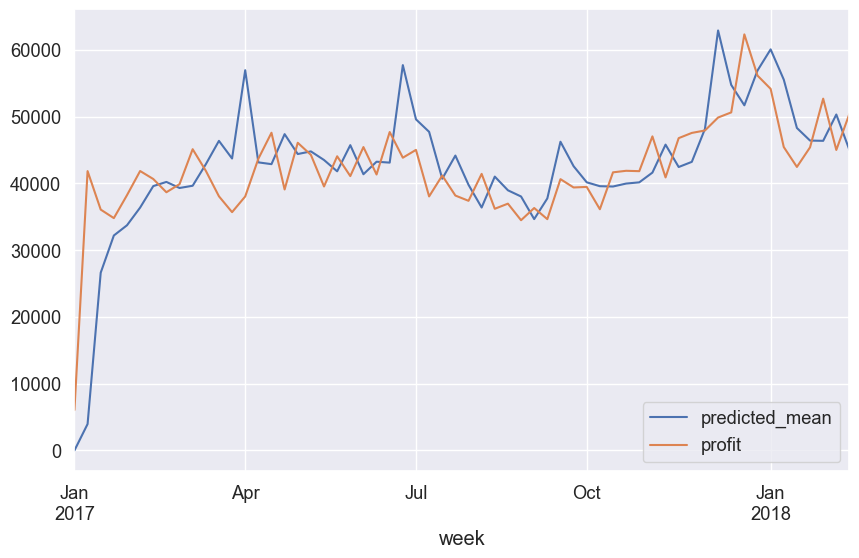

In [153]:
plt.figure(figsize=(10, 6))
train_prediction.plot(legend=True)
X_train['profit'].plot(legend=True)

In [154]:
print('Absolute Error:', metrics.mean_absolute_error(X_train, train_prediction))
print('MSE:', metrics.mean_squared_error(X_train, train_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_train, train_prediction)))

Absolute Error: 5189.77274683189
MSE: 57863954.63441036
RMSE: 7606.836046242245


<Axes: xlabel='week'>

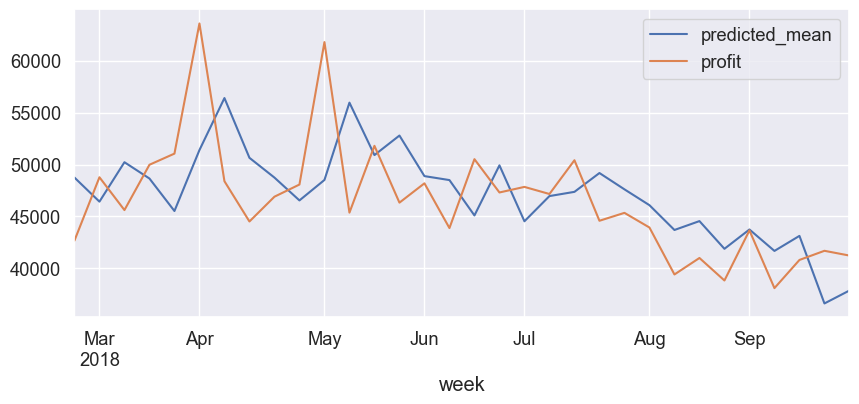

In [155]:
plt.figure(figsize=(10, 4))
prediction.plot(legend=True)
X_test['profit'].plot(legend=True)

In [156]:
print('Absolute Error:', metrics.mean_absolute_error(X_test, prediction))
print('MSE:', metrics.mean_squared_error(X_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_test, prediction)))

Absolute Error: 4217.342041552112
MSE: 27713094.3937051
RMSE: 5264.3227858581295


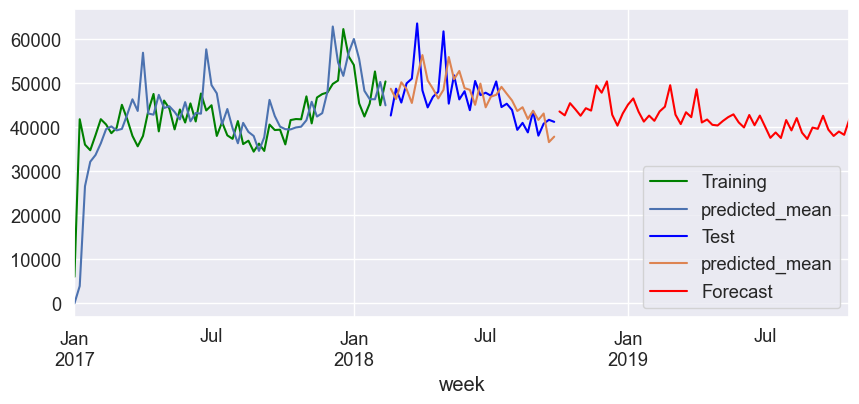

In [158]:
forecast=result.predict(len(profit_weekly), (len(profit_weekly)-1)+56).rename('Forecast')

plt.figure(figsize=(10,4))

X_train['profit'].plot(label="Training",color='green')
train_prediction.plot(legend=True)
X_test['profit'].plot(label="Test",color='blue')
prediction.plot(legend=True)
forecast.plot(label="Forecast",color="red")
plt.legend(loc="lower right")

### 8 - Inventory

In [161]:
out_of_stock = pd.merge(i_df, p_df, on='Product_ID')
out_of_stock = pd.merge(out_of_stock, st_df, on='Store_ID')
out_of_stock = out_of_stock[out_of_stock['Stock_On_Hand'] == 0]
out_of_stock

,Store_ID,Product_ID,Stock_On_Hand,Product_Name,Product_Category,Product_Cost,Product_Price,Store_Name,Store_City,Store_Location,Store_Open_Date
1,1,2,0,Animal Figures,Toys,$9.99,$12.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18
4,1,5,0,Classic Dominoes,Games,$7.99,$9.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18
33,1,34,0,Toy Robot,Electronics,$20.99,$25.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18
35,2,1,0,Action Figure,Toys,$9.99,$15.99,Maven Toys Monterrey 1,Monterrey,Residential,1995-04-27
41,2,9,0,Dino Egg,Toys,$9.99,$10.99,Maven Toys Monterrey 1,Monterrey,Residential,1995-04-27
...,...,...,...,...,...,...,...,...,...,...,...
1520,48,33,0,Teddy Bear,Toys,$10.99,$12.99,Maven Toys Saltillo 2,Saltillo,Commercial,2016-03-23
1524,49,2,0,Animal Figures,Toys,$9.99,$12.99,Maven Toys Culiacan 1,Culiacan,Downtown,2016-05-10
1537,49,15,0,Hot Wheels 5-Pack,Toys,$3.99,$5.99,Maven Toys Culiacan 1,Culiacan,Downtown,2016-05-10
1569,50,12,0,Foam Disk Launcher,Sports & Outdoors,$8.99,$11.99,Maven Toys Guanajuato 3,Guanajuato,Residential,2016-05-18


In [162]:
sale_for_out = pd.DataFrame(sales2.groupby([sales2['Date'].dt.year.rename('year'), sales2['Date'].dt.to_period("M").rename('month'), 'Product_Name', 'Store_Location'])['Units'].sum().reset_index())
sale_for_out = sale_for_out[sale_for_out['month'] == '2018-09']
sale_for_out

,year,month,Product_Name,Store_Location,Units
2325,2018,2018-09,Action Figure,Airport,42
2326,2018,2018-09,Action Figure,Commercial,281
2327,2018,2018-09,Action Figure,Downtown,1062
2328,2018,2018-09,Action Figure,Residential,277
2329,2018,2018-09,Animal Figures,Airport,37
...,...,...,...,...,...
2454,2018,2018-09,Toy Robot,Downtown,335
2455,2018,2018-09,Toy Robot,Residential,50
2456,2018,2018-09,Uno Card Game,Commercial,58
2457,2018,2018-09,Uno Card Game,Downtown,87


In [163]:
out_of_stock['Product_Cost'] = out_of_stock['Product_Cost'].str.replace('$', '')
out_of_stock['Product_Cost'] = out_of_stock['Product_Cost'].str.replace(' ', '')
out_of_stock['Product_Price'] = out_of_stock['Product_Price'].str.replace('$', '')
out_of_stock['Product_Price'] = out_of_stock['Product_Price'].str.replace(' ', '')

out_of_stock['Product_Cost'] = out_of_stock['Product_Cost'].astype(float)
out_of_stock['Product_Price'] = out_of_stock['Product_Price'].astype(float)

out_of_stock

,Store_ID,Product_ID,Stock_On_Hand,Product_Name,Product_Category,Product_Cost,Product_Price,Store_Name,Store_City,Store_Location,Store_Open_Date
1,1,2,0,Animal Figures,Toys,9.99,12.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18
4,1,5,0,Classic Dominoes,Games,7.99,9.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18
33,1,34,0,Toy Robot,Electronics,20.99,25.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18
35,2,1,0,Action Figure,Toys,9.99,15.99,Maven Toys Monterrey 1,Monterrey,Residential,1995-04-27
41,2,9,0,Dino Egg,Toys,9.99,10.99,Maven Toys Monterrey 1,Monterrey,Residential,1995-04-27
...,...,...,...,...,...,...,...,...,...,...,...
1520,48,33,0,Teddy Bear,Toys,10.99,12.99,Maven Toys Saltillo 2,Saltillo,Commercial,2016-03-23
1524,49,2,0,Animal Figures,Toys,9.99,12.99,Maven Toys Culiacan 1,Culiacan,Downtown,2016-05-10
1537,49,15,0,Hot Wheels 5-Pack,Toys,3.99,5.99,Maven Toys Culiacan 1,Culiacan,Downtown,2016-05-10
1569,50,12,0,Foam Disk Launcher,Sports & Outdoors,8.99,11.99,Maven Toys Guanajuato 3,Guanajuato,Residential,2016-05-18


In [164]:
out_of_stock.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 1 to 1585
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Store_ID          77 non-null     int64         
 1   Product_ID        77 non-null     int64         
 2   Stock_On_Hand     77 non-null     int64         
 3   Product_Name      77 non-null     object        
 4   Product_Category  77 non-null     object        
 5   Product_Cost      77 non-null     float64       
 6   Product_Price     77 non-null     float64       
 7   Store_Name        77 non-null     object        
 8   Store_City        77 non-null     object        
 9   Store_Location    77 non-null     object        
 10  Store_Open_Date   77 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 7.2+ KB


In [165]:
sales_loss = pd.merge(out_of_stock, sale_for_out, on=['Product_Name', 'Store_Location'])
sales_loss['loss'] = sales_loss['Units'] * (sales_loss['Product_Price']-sales_loss['Product_Cost'])
sales_loss

,Store_ID,Product_ID,Stock_On_Hand,Product_Name,Product_Category,Product_Cost,Product_Price,Store_Name,Store_City,Store_Location,Store_Open_Date,year,month,Units,loss
0,1,2,0,Animal Figures,Toys,9.99,12.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18,2018,2018-09,204,612.00
1,1,5,0,Classic Dominoes,Games,7.99,9.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18,2018,2018-09,25,50.00
2,1,34,0,Toy Robot,Electronics,20.99,25.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18,2018,2018-09,50,250.00
3,2,1,0,Action Figure,Toys,9.99,15.99,Maven Toys Monterrey 1,Monterrey,Residential,1995-04-27,2018,2018-09,277,1662.00
4,44,1,0,Action Figure,Toys,9.99,15.99,Maven Toys Puebla 3,Puebla,Residential,2014-12-27,2018,2018-09,277,1662.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,42,16,0,Jenga,Games,2.99,9.99,Maven Toys Hermosillo 3,Hermosillo,Commercial,2014-06-27,2018,2018-09,28,196.00
73,44,33,0,Teddy Bear,Toys,10.99,12.99,Maven Toys Puebla 3,Puebla,Residential,2014-12-27,2018,2018-09,9,18.00
74,45,9,0,Dino Egg,Toys,9.99,10.99,Maven Toys Ciudad de Mexico 4,Cuidad de Mexico,Commercial,2015-06-21,2018,2018-09,579,579.00
75,50,12,0,Foam Disk Launcher,Sports & Outdoors,8.99,11.99,Maven Toys Guanajuato 3,Guanajuato,Residential,2016-05-18,2018,2018-09,117,351.00


In [166]:
print('According to the last months data, The Loss from out of Stock Products for 1 month is', sales_loss['loss'].sum(), 'Dollars')

According to the last months data, The Loss from out of Stock Products for 1 month is 225171.0 Dollars


In [167]:
in_stock = pd.merge(i_df, p_df, on='Product_ID')
in_stock = pd.merge(in_stock, st_df, on='Store_ID')

in_stock['Product_Cost'] = in_stock['Product_Cost'].str.replace('$', '')
in_stock['Product_Cost'] = in_stock['Product_Cost'].str.replace(' ', '')
in_stock['Product_Price'] = in_stock['Product_Price'].str.replace('$', '')
in_stock['Product_Price'] = in_stock['Product_Price'].str.replace(' ', '')

in_stock['Product_Cost'] = in_stock['Product_Cost'].astype(float)
in_stock['Product_Price'] = in_stock['Product_Price'].astype(float)

in_stock['Total']= in_stock['Product_Price'] * in_stock['Stock_On_Hand']
print('According to the inventory data, Total money tied up in inventory at the toy stores is', in_stock['Total'].sum(), 'Dollars') 

According to the inventory data, Total money tied up in inventory at the toy stores is 410240.57999999996 Dollars
